# **Problem Statement**

- Scaler is an online tech-versity offering intensive computer science & Data Science courses through live classes delivered by tech leaders and subject matter experts. The meticulously structured program enhances the skills of software professionals by offering a modern curriculum with exposure to the latest technologies. It is a product by InterviewBit.

- You are working as a data scientist with the analytics vertical of Scaler, focused on profiling the best companies and job positions to work for from the Scaler database. You are provided with the information for a segment of learners and tasked to cluster them on the basis of their job profile, company, and other features.

# **Loading dependencies and dataset**

In [1]:
# !pip install python-Levenshtein
# !pip install fuzzywuzzy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz

# from scipy.stats import levene, f_oneway, kruskal
# from scipy.stats import ttest_ind
# from scipy.stats import chi2_contingency
# from statsmodels.graphics.gofplots import qqplot

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform


import plotly.express as px


import scipy.cluster.hierarchy as sch

In [2]:
df = pd.read_csv('./data/scaler.csv')
df.head()

Unnamed: 0               company_hash  \
0           0             atrgxnnt xzaxv   
1           1  qtrxvzwt xzegwgbb rxbxnta   
2           2              ojzwnvwnxw vx   
3           3                  ngpgutaxv   
4           4                 qxen sqghu   

                                          email_hash  orgyear      ctc  \
0  6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...   2016.0  1100000   
1  b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...   2018.0   449999   
2  4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...   2015.0  2000000   
3  effdede7a2e7c2af664c8a31d9346385016128d66bbc58...   2017.0   700000   
4  6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...   2017.0  1400000   

         job_position  ctc_updated_year  
0               Other            2020.0  
1  FullStack Engineer            2019.0  
2    Backend Engineer            2020.0  
3    Backend Engineer            2019.0  
4  FullStack Engineer            2019.0

# **Basic checks on the data**

In [3]:
df.shape

(205843, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153281 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [5]:
# Dropping unnecessary columns
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
# Total duplicate rows across all columns
df.duplicated().sum()

33

In [7]:
# Checking for duplicate rows across all columns
df.loc[df.duplicated(keep='first')]

company_hash  \
97138                            wtqtzwt xzw   
98085                                   2020   
102600                          voxvz uvxzno   
109324                      wgbwvon mhoxztoo   
111354             uyxrxuo xzzgcvnxgz wvbuho   
111521                      aqggb ntwyzgrgsj   
115241                   rgfto wgbuvzxto xzw   
117246                                xatbxv   
117549                               exzdtqv   
120371  avnvbtnxwv ogrhnxgzo uqxcvnt rxbxnta   
121946                          oguqv ontqxv   
122316                               eqtoytq   
130495                                xatbxv   
138371                                 xicxv   
141686                      uhmrxwxo ovuxtzn   
143061   vwwtznhqt ogrhnxgzo uqxcvnt rxbxnta   
146097                          axvouvqp xzw   
151473                   rgfto wgbuvzxto xzw   
157950                        ti ntwyzgrgsxw   
161251                     avnvftvct ucn rna   
164554                            ng nyt ztf   
165326                      uhmrxwxo ovuxtzn   
171421                               fyvnexd   
175942                            tdnqvbvqpo   
179858                           buyvoxo rna   
180630                      uhmrxwxo ovuxtzn   
182531                             xznqvrxzp   
195375               souvzz ntwyzgrgsxto xzw   
196492                                  2020   
196971                                  2020   
201165                            xzzgcvwwtq   
203257                      uhmrxwxo ovuxtzn   
205733                      uhmrxwxo ovuxtzn   

                                               email_hash  orgyear      ctc  \
97138   bb8e4b09544daf1bfc8c7bb9a9ae1fee35490cf3f321b8...   2014.0  1000000   
98085   6ad3e6ab27462c2c7428fa5d51405933335341d4d969b5...   2020.0   720000   
102600  c7fac937a34f7ae432ff1d77466eb7ea6cf25dfd5ebcca...   2020.0  1280000   
109324  0442a51ef5080d7d40721c007131a1d5bdeabae2c1b153...   2016.0   700000   
111354  704d69965035d1c341b06fc5d83bf1b714f1625c0cf271...   2017.0   850000   
111521  df81dac132d66a42a0c71a4799e1040731738e542c81ff...   2017.0  1270000   
115241  ea363e930dabe0fbb63438e07775af3cb3b32639947c47...   2017.0  1100000   
117246  f451ceee50b1bfa3dc749c6aa8634ab3851a4ab961b003...   2019.0   640000   
117549  e7df851527dd6f8ec95d5e13d9fb2a7255380245b808e3...   2020.0  1500000   
120371  15d7dd6801fb7cb980e77c420dd9bef5773e7ef57f510c...   2016.0  1300000   
121946  f48d4cd35091adb89c8e82b8bc39b68416e2e954e406fd...   2016.0  1250000   
122316  567e7ff3ad74ce235a75b1feea224204d35cd698922e59...   2018.0   900000   
130495  80a04f3eb89aa385e32b6e1c9a0b564730274632fad4c4...   2017.0   409999   
138371  d0e72d551c69a2f9d96914515aeef797f4989b54c90ef0...   2014.0  1200000   
141686  f27a6a759a02e90ebd17041fb26b72d13420d53edcdc99...   2020.0   940000   
143061  bf09ce2b61e3bba0846412cf76b2e408c92384b373f709...   2014.0   800000   
146097  8e5fe3154be66d7cd8730224318d913ecd10ec5197e20a...   2017.0  1000000   
151473  f67d3be9653bca997a75c81a88e851bcf0368fd83255aa...   2017.0  1265000   
157950  843a5216e56e06b9d31d35e0c3820beec3af19dc4978af...   2019.0   850000   
161251  5083a995fa1623fd7d329766f8e7adbe5497a8c3c826f9...   2018.0   800000   
164554  7b47ee99ce695d48d18dea36d3c6cc73e3b5b40ed477cf...   2019.0   450000   
165326  d40b483baf912b9f21cd1952e8b79388ce88ed5222d3d8...   2019.0  1200000   
171421  7e2ac7c6b9051177ea51af3f7c8e934d6d3ce15a5cb587...   2020.0  1300000   
175942  82b93606127fa5ed0d28cb32469d7ba177b8e70088608c...   2019.0   350000   
179858  bd443574985b2f72a4a382b6be392db2358158761f38de...   2016.0   750000   
180630  59e67f9f149ede96889afacb1a70645fd3f309e3a1fa43...   2019.0  1620000   
182531  c2c34a82a91169e2523727f7f15a4cc64f973ccb895b69...   2016.0  6730000   
195375  31fefa78a0f32b56c8f0d60d2355d92c480b4ba95fcd83...   2018.0   600000   
196492  b6a63b76c3a1a395f7c3d509f2760d83aeb6e8c53db2b1...   2020.0  2700000   
196971  77a5cecd2ed9bb764df8b

In [8]:
# Dropping duplicate rows
df.drop_duplicates(keep='first', inplace=True)

In [9]:
# Missing values in dataset:
df.isna().sum()

company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52547
ctc_updated_year        0
dtype: int64

In [10]:
# Missing values in dataset:
100*df.isna().sum()/df.shape[0]

company_hash         0.021379
email_hash           0.000000
orgyear              0.041786
ctc                  0.000000
job_position        25.531801
ctc_updated_year     0.000000
dtype: float64

# **EDA:**

In [11]:
# Segregating numerical and categorical columns
cat_cols = []
num_cols = []
for col in df.columns:
    if df[col].dtype=='object':
        cat_cols.append(col)
    else:
        num_cols.append(col)
        
print('Categorical Columns:', cat_cols)
print('Numerical Columns:', num_cols)

Categorical Columns: ['company_hash', 'email_hash', 'job_position']
Numerical Columns: ['orgyear', 'ctc', 'ctc_updated_year']


## **Univaritate Analysis**

In [12]:
df.describe(include='O')

company_hash  \
count                      205766   
unique                      37299   
top     nvnv wgzohrnvzwj otqcxwto   
freq                         8337   

                                               email_hash      job_position  
count                                              205810            153263  
unique                                             153443              1017  
top     bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...  Backend Engineer  
freq                                                   10             43546

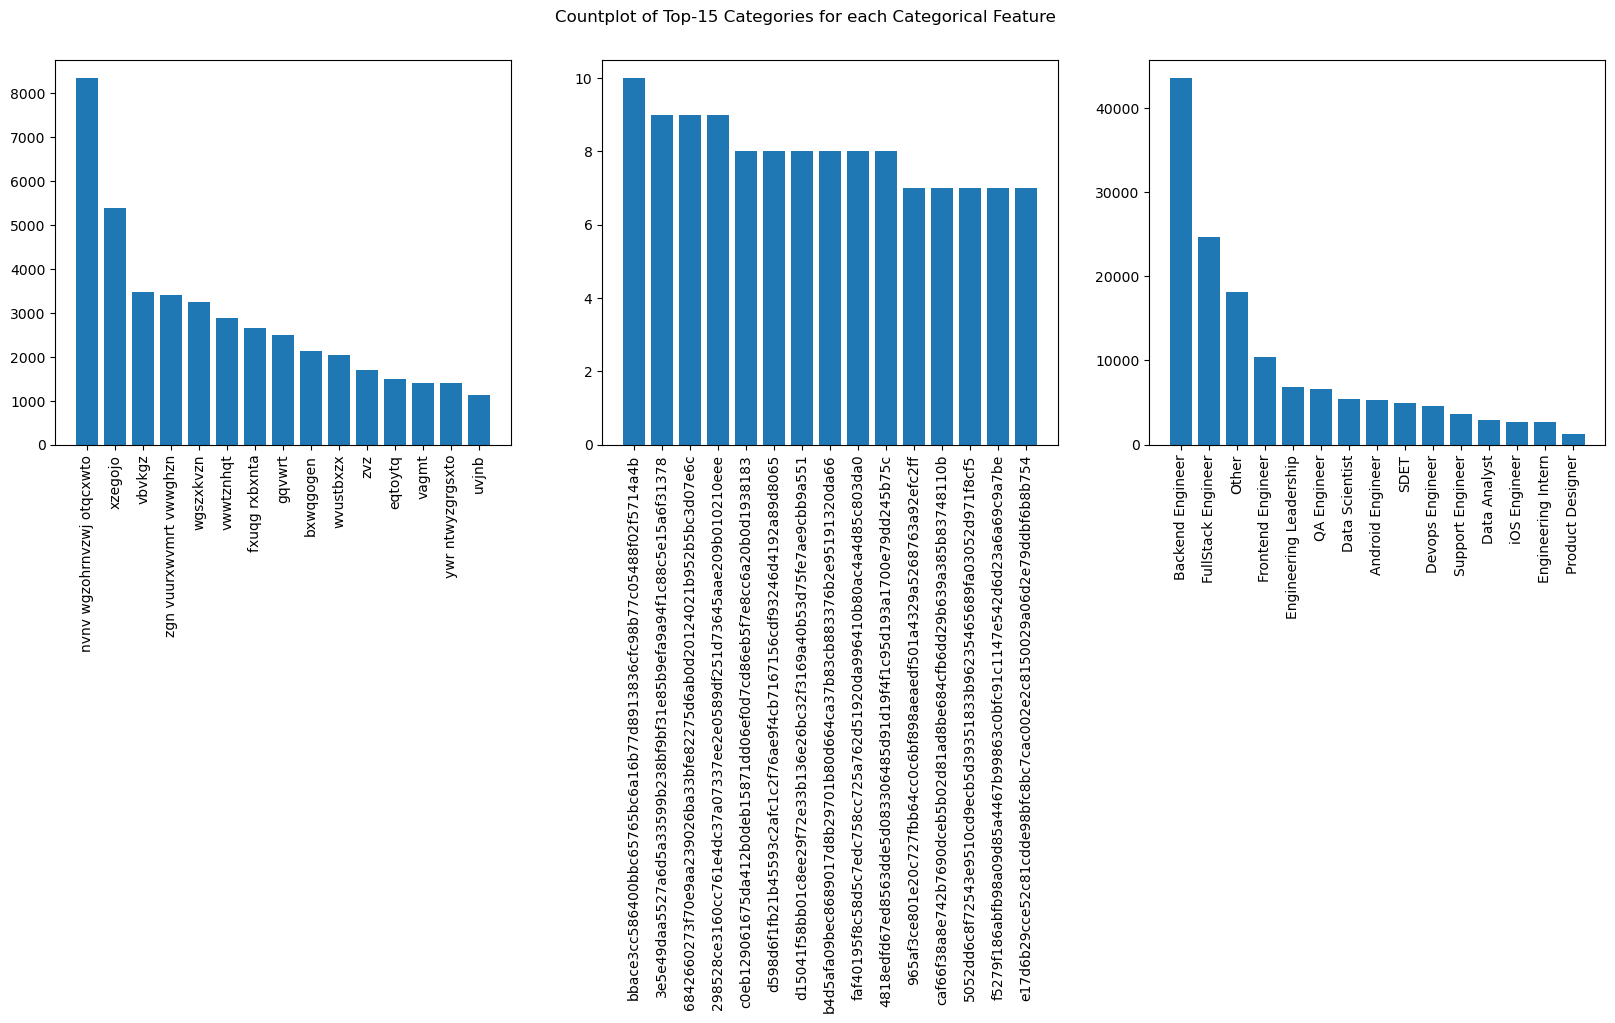

In [13]:
# Countplot: Categorical features (top 15 most frequent categories)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
i = 0
for col in cat_cols:

    axs[i].bar(df[col].value_counts()[:15].index, df[col].value_counts()[:15])
    axs[i].tick_params(axis='x', rotation=90) 
    # axs[i].xticks(rotation=90)
    i += 1

plt.suptitle('Countplot of Top-15 Categories for each Categorical Feature')
plt.show()

In [14]:
df.describe()

orgyear           ctc  ctc_updated_year
count  205724.000000  2.058100e+05     205810.000000
mean     2014.882284  2.271854e+06       2019.628279
std        63.576199  1.180185e+07          1.325188
min         0.000000  2.000000e+00       2015.000000
25%      2013.000000  5.300000e+05       2019.000000
50%      2016.000000  9.500000e+05       2020.000000
75%      2018.000000  1.700000e+06       2021.000000
max     20165.000000  1.000150e+09       2021.000000

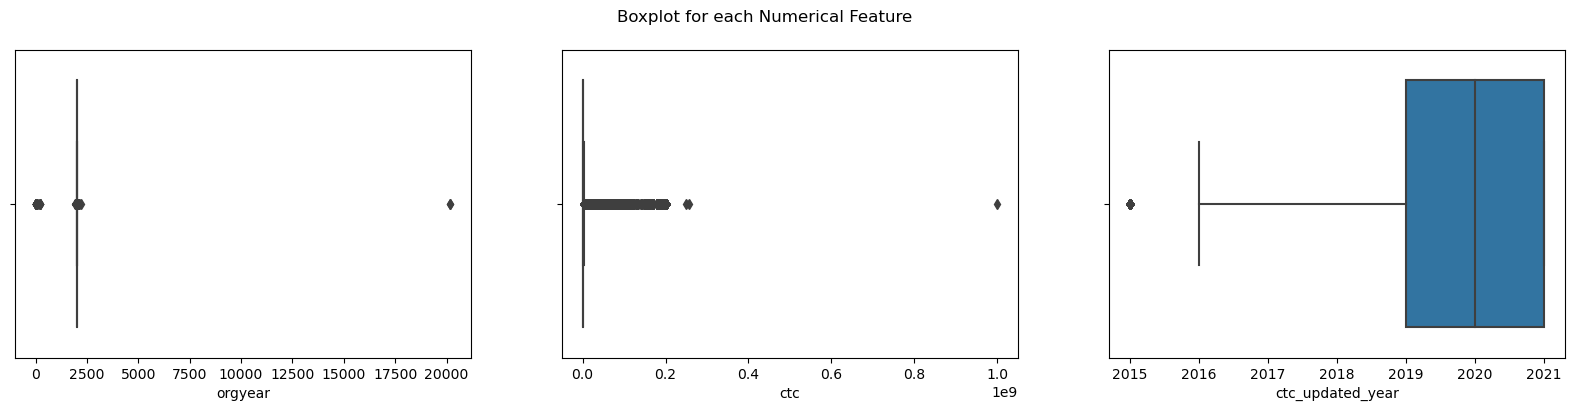

In [15]:
# Distribution: Numerical features
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
# i = 0
# for col in num_cols:
#     sns.boxplot(x=df[col], ax=axs[i][0])
#     if col in ['orgyear', 'ctc_updated_year']:
#         # sns.countplot(df[col], ax=axs[i][1])
#         df[col].plot.hist(bins=50, ax=axs[i][1], color='blue')
#     df[col].plot.hist(bins=10, ax=axs[i][1])
#     i += 1

# plt.suptitle('Distribution for each Numerical Feature')


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
i = 0
for col in num_cols:
    sns.boxplot(x=df[col], ax=axs[i])
    i += 1

plt.suptitle('Boxplot for each Numerical Feature')

plt.show()

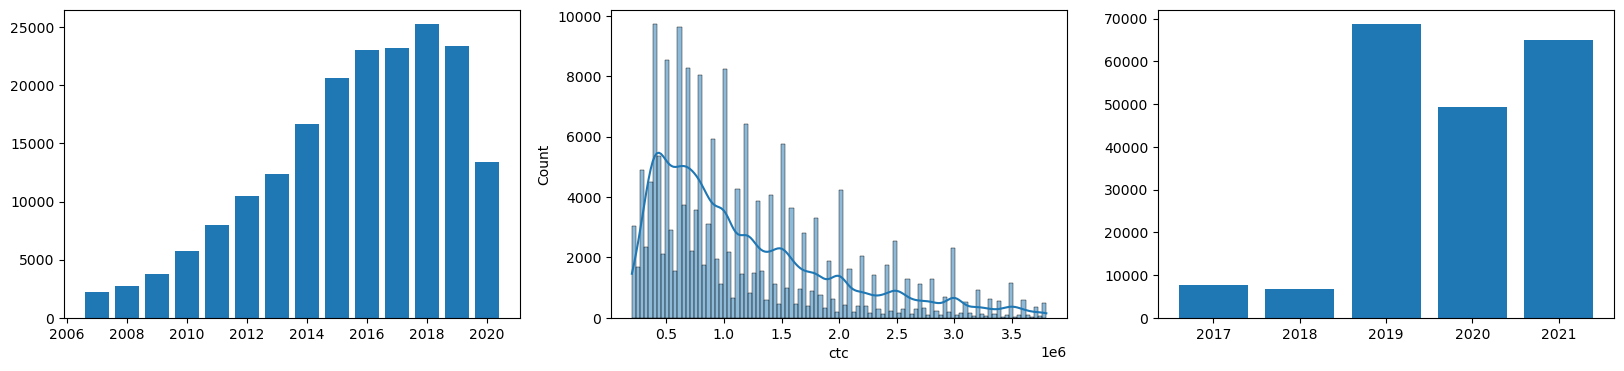

In [16]:
# As seen from box-plots there are many outliers in the numerical features. We will focus on values b/w 5p and 95p and check the distributions

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

i = 0
for col in num_cols:
    # only looking at the values b/w 5th and 95th percentiles
    ser_col = df.loc[((df[col]>=df[col].quantile(0.05)) & (df[col]<=df[col].quantile(0.95))), col]
    if col=='ctc':
        sns.histplot(ser_col, bins=100, ax=axs[i], kde=True)
    else:
        axs[i].bar(ser_col.value_counts().index, ser_col.value_counts().values)
        
    i += 1
plt.show()

## **Bivariate Analysis**

In [17]:
# We will only consider the middle 90% of data for ctc and orgyear for first cut analysis, we will treat outliers later
ctc_5p = df['ctc'].quantile(0.05)
ctc_95p = df['ctc'].quantile(0.95)

orgyr_5p = df['orgyear'].quantile(0.05)
orgyr_95p = df['orgyear'].quantile(0.95)

df_eda = df.loc[((df['ctc']>=ctc_5p) & (df['ctc']<=ctc_95p)) & ((df['orgyear']>=orgyr_5p) & (df['orgyear']<=orgyr_95p))].copy()

### **Relationship between ctc & orgyear**

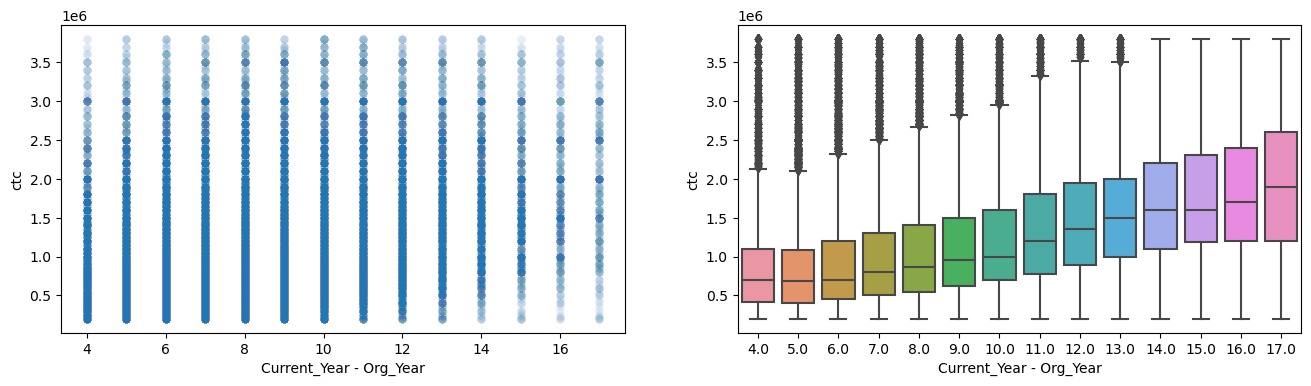

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

sns.scatterplot(y=df_eda['ctc'], x=2024-df_eda['orgyear'], ax=axs[0], alpha=0.01)
axs[0].set_xlabel('Current_Year - Org_Year')

sns.boxplot(y=df_eda['ctc'], x=2024-df_eda['orgyear'], ax=axs[1])
axs[1].set_xlabel('Current_Year - Org_Year')
plt.show()

### **Mean CTC of Top15 and Bottom15 Job descriptions**

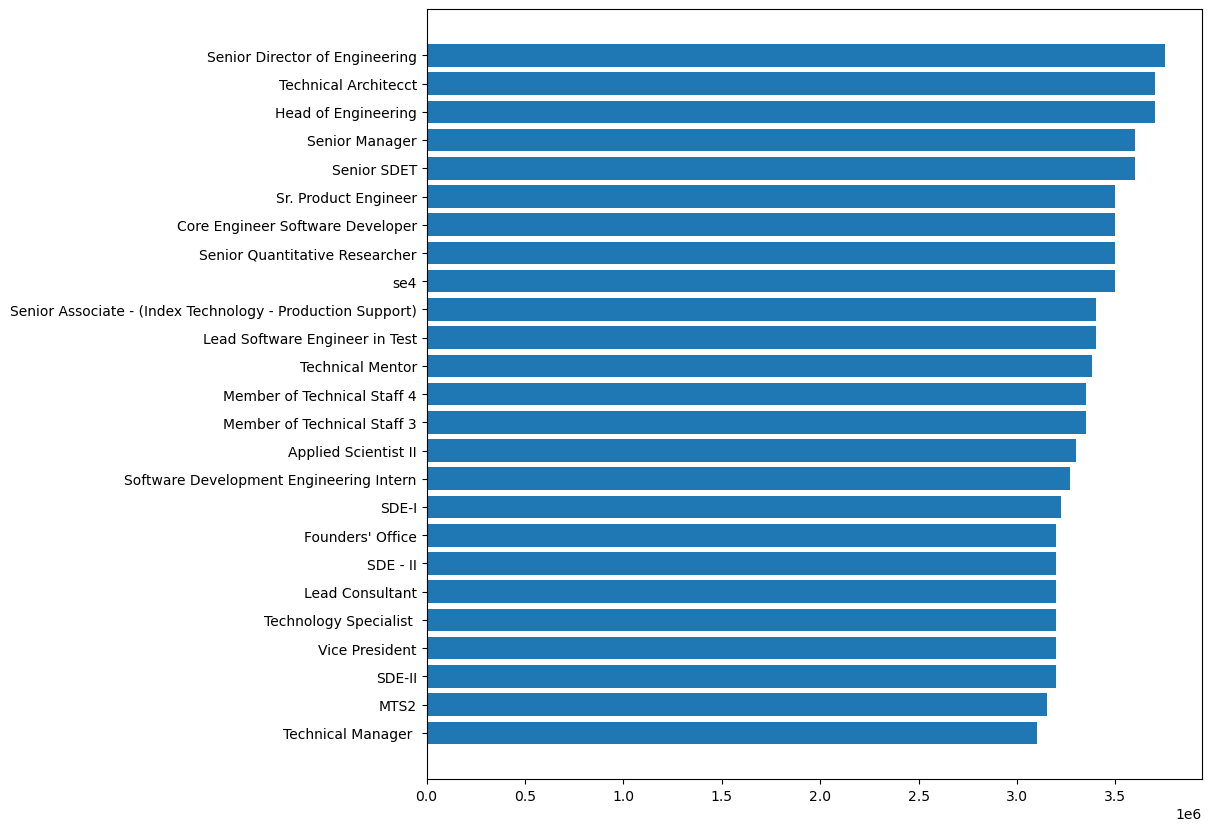

In [19]:
# Top-25
plt.figure(figsize=(10, 10))
plt.barh(df_eda.groupby('job_position')['ctc'].mean().sort_values(ascending=False).iloc[:25].index[::-1], 
        df_eda.groupby('job_position')['ctc'].mean().sort_values(ascending=False).iloc[:25].values[::-1])
plt.show()

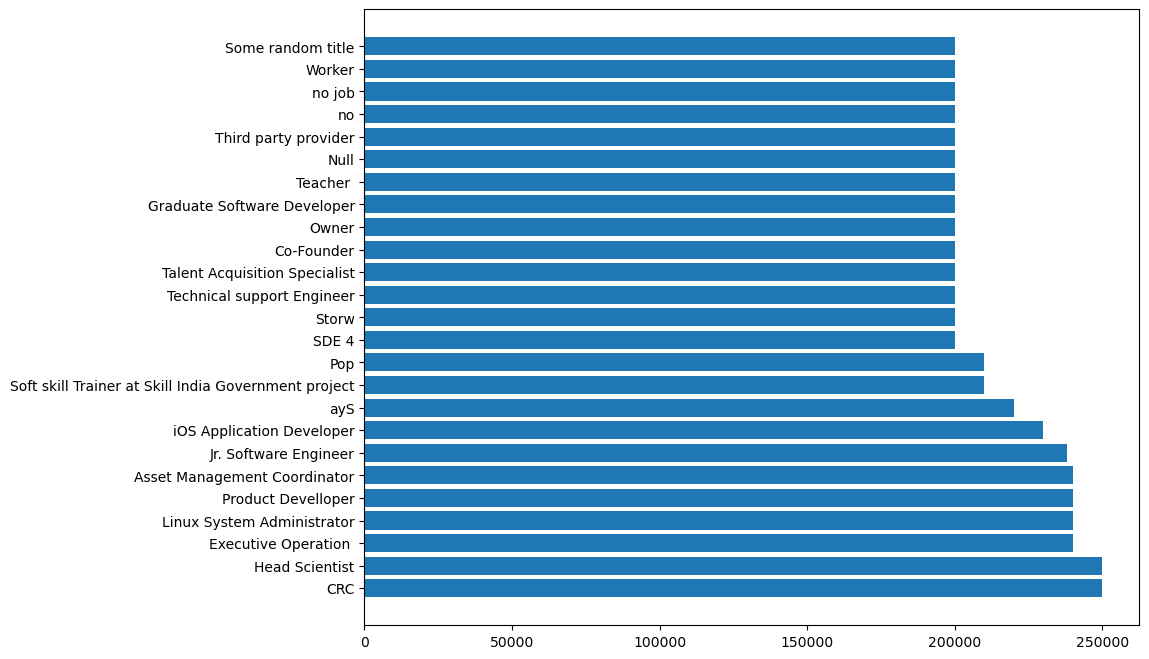

In [20]:
# Bottom-25
plt.figure(figsize=(10, 8))
plt.barh(df_eda.groupby('job_position')['ctc'].mean().sort_values(ascending=True).iloc[:25].index[::-1], 
        df_eda.groupby('job_position')['ctc'].mean().sort_values(ascending=True).iloc[:25].values[::-1])
plt.show()

## **Observations from EDA:**

1. *ctc, oreyear have outliers and it needs to be treated. Aside from the outliers:*
- ctc follows a log-normal distribution with a heavy rhs tail 
- orgyear is also a skewed distribution but skewness is less compared to ctc

2. *For any particular orgyear, the variablity in the ctc is high (as seen from the boxplot is bivariate section).*
- This is expected since orgyear as a variable which tells the joining date for a learner in current company
- For example someone with 20years of overall experience can join his current company 1 year back and thus can have a high ctc
- However the general trend can be seen if we track the median ctc across orgyear, learners with high years of expereince in current position tend to have a higher ctc
    
3. *There are many job positions 1017 unique job positions but many out of then are eseentially the same job position if observered closely.*
- These are showing up as unique categories due to uneven string format, spelling errors and so on. 
- They can be cleaned to make the dataset proper

4. *Missing values are present in company_hash, orgyear and job_position. We will have to take of those missing values.*
- Company_hash and orgyear have <0.05% missing values (Simple Imputation techniques like mode can be a possible solution)
- Job_position has ~25% missing values (KNN Imputation may be a possible option)


# **Data-Preprocessing**

## **Data Cleaning of Duplicate Values**

### **Data Cleaning - Part 1**

We will first group by the whole dataset on the below 4 features:
- email_hash
- company_hash
- orgyear
- ctc_updated_year

In [21]:
# Cheking m,issing values in these 4 features --> only 2 features have missing values
df[['email_hash', 'company_hash', 'orgyear', 'ctc_updated_year']].isna().sum()

email_hash           0
company_hash        44
orgyear             86
ctc_updated_year     0
dtype: int64

In [22]:
print('Total missing values in 2 features:', 44 + 86)
print('Rows impacted by missing values in the above 2 features:', np.any(df[['email_hash', 'company_hash', 'orgyear', 'ctc_updated_year']].isna(), axis=1).sum())
print('Rows NOT impacted by missing values:', df.shape[0]-130)

Total missing values in 2 features: 130
Rows impacted by missing values in the above 2 features: 130
Rows NOT impacted by missing values: 205680


#### **Data Cleaning - Part 1 (Approach)**

We only focus on 4 features of the dataset here (email_hash, company_hash, orgyear, ctc_updated_year)
- SetA: In these 205680 rows, none of the features are missing here. However we have duplicates as shown in the examples below, so we will need to drop them anyways
- SetB: In these 130 rows, either company_hash or orgyear is missing
- From SetB, we only preserve those learners who are not found in SetA and drop the rows of those learners whose records are found in SetA

#### **SetA**

In [23]:
df_tst1 = df.groupby(['email_hash', 'company_hash', 'orgyear', 'ctc_updated_year'])[['ctc_updated_year']].agg(count=('ctc_updated_year','count')).reset_index()
df_tst1['count'].value_counts()

1    129707
2     31199
3      3735
4       450
5        83
6        18
7         3
9         2
8         1
Name: count, dtype: int64

In [24]:
# df_tst1.loc[df_tst1['ctc']==9, 'email_hash'].values
# df_tst1.loc[df_tst1['ctc']==8, 'email_hash'].values
# df_tst1.loc[df_tst1['ctc']==5, 'email_hash'].values

**SetA: Example1 with duplicate values**

In [25]:
df.loc[df['email_hash']=='298528ce3160cc761e4dc37a07337ee2e0589df251d73645aae209b010210eee']

company_hash                                         email_hash  \
65909   cvrhtbgbtznhb  298528ce3160cc761e4dc37a07337ee2e0589df251d736...   
72799   cvrhtbgbtznhb  298528ce3160cc761e4dc37a07337ee2e0589df251d736...   
82099   cvrhtbgbtznhb  298528ce3160cc761e4dc37a07337ee2e0589df251d736...   
93495   cvrhtbgbtznhb  298528ce3160cc761e4dc37a07337ee2e0589df251d736...   
93783   cvrhtbgbtznhb  298528ce3160cc761e4dc37a07337ee2e0589df251d736...   
190903  cvrhtbgbtznhb  298528ce3160cc761e4dc37a07337ee2e0589df251d736...   
191498  cvrhtbgbtznhb  298528ce3160cc761e4dc37a07337ee2e0589df251d736...   
196685  cvrhtbgbtznhb  298528ce3160cc761e4dc37a07337ee2e0589df251d736...   
201587  cvrhtbgbtznhb  298528ce3160cc761e4dc37a07337ee2e0589df251d736...   

        orgyear     ctc        job_position  ctc_updated_year  
65909    2018.0  720000    Backend Engineer            2020.0  
72799    2018.0  720000  Research Engineers            2020.0  
82099    2018.0  720000               Other            2020.0  
93495    2018.0  720000                 NaN            2020.0  
93783    2018.0  720000      Data Scientist            2020.0  
190903   2018.0  700000               Other            2020.0  
191498   2018.0  700000  Research Engineers            2020.0  
196685   2018.0  700000      Data Scientist            2020.0  
201587   2018.0  700000    Backend Engineer            2020.0

**SetA: Example2 with duplicate values**

In [26]:
df.loc[df['email_hash']=='b4d5afa09bec8689017d8b29701b80d664ca37b83cb883376b2e95191320da66']

company_hash                                         email_hash  \
37734   bvi ogenfvqt  b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...   
45982   bvi ogenfvqt  b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...   
144760  bvi ogenfvqt  b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...   
151714  bvi ogenfvqt  b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...   
153866  bvi ogenfvqt  b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...   
154644  bvi ogenfvqt  b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...   
197145  bvi ogenfvqt  b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...   
203171  bvi ogenfvqt  b4d5afa09bec8689017d8b29701b80d664ca37b83cb883...   

        orgyear      ctc            job_position  ctc_updated_year  
37734    2020.0   900000  Engineering Leadership            2021.0  
45982    2020.0   900000      Engineering Intern            2021.0  
144760   2020.0   900000            Data Analyst            2021.0  
151714   2020.0   900000          Data Scientist            2021.0  
153866   2020.0   900000                     NaN            2021.0  
154644   2020.0   900000     Software Engineer 1            2021.0  
197145   2020.0  2000000      Engineering Intern            2021.0  
203171   2020.0  2000000            Data Analyst            2021.0

**SetA: Example3 with duplicate values**

In [27]:
df.loc[df['email_hash']=='bbace3cc586400bbc65765bc6a16b77d8913836cfc98b77c05488f02f5714a4b']

company_hash  \
24109   oxej ntwyzgrgsxto rxbxnta   
45984   oxej ntwyzgrgsxto rxbxnta   
72315   oxej ntwyzgrgsxto rxbxnta   
102915  oxej ntwyzgrgsxto rxbxnta   
117764  oxej ntwyzgrgsxto rxbxnta   
121483  oxej ntwyzgrgsxto rxbxnta   
124476  oxej ntwyzgrgsxto rxbxnta   
144479  oxej ntwyzgrgsxto rxbxnta   
152801  oxej ntwyzgrgsxto rxbxnta   
159835  oxej ntwyzgrgsxto rxbxnta   

                                               email_hash  orgyear     ctc  \
24109   bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...   2018.0  720000   
45984   bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...   2018.0  720000   
72315   bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...   2018.0  720000   
102915  bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...   2018.0  720000   
117764  bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...   2018.0  720000   
121483  bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...   2018.0  660000   
124476  bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...   2018.0  660000   
144479  bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...   2018.0  660000   
152801  bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...   2018.0  660000   
159835  bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...   2018.0  660000   

              job_position  ctc_updated_year  
24109                  NaN            2020.0  
45984     Support Engineer            2020.0  
72315                Other            2020.0  
102915  FullStack Engineer            2020.0  
117764        Data Analyst            2020.0  
121483               Other            2019.0  
124476    Support Engineer            2019.0  
144479  FullStack Engineer            2019.0  
152801     Devops Engineer            2019.0  
159835                 NaN            2019.0

#### **SetB**

In [28]:
df_miss_val = df.loc[df['company_hash'].isna() | df['orgyear'].isna(), ['email_hash']]
df_miss_val_tst1_lj = pd.merge(df_miss_val, df_tst1, on=['email_hash'], how='left', indicator=True)
df_miss_val_tst1_lj['_merge'].value_counts()

left_only     117
both           13
right_only      0
Name: _merge, dtype: int64

In [29]:
# Learners who are found in both SetA and SetB
df_miss_val_tst1_lj.loc[df_miss_val_tst1_lj['_merge']=='both']

email_hash           company_hash  \
8    6eb55d779699a2ea94f340ab7a58c8ec505e38bbb41214...    hzxnta ntwyzgrgsxto   
9    18813fe2a50a45cc02c5b3871c676bd147c80ff0327ee9...                xzegojo   
10   0e25bf875aaa6550db1aa9f9452179ed1cd6737c079fbc...          sgrabvz ovwyo   
19   b4a56d1199bc569aabd30cba8ea7a86fbddc85211453ba...                    exo   
26   ecf94874c8c63483c18277817848cd6507d8b78dd00474...                 vbvkgz   
33   d76c197d014cc42d3f7f77f278f7a313a316c3db7e96a3...          x3 wgzohrnxzs   
39   5721ff19939451f5e0c6743133acd64d67f3e372229759...                   nojo   
43   b17c74b195c1fa8038bf82c674716ae81b41b995a3b434...  xzaho cvrrtj uvqnztqo   
54   da4d1843baedd22459d7a8d08344375cc8752d1dcfe211...                wvqfvrt   
89   d7f39bfaa3be4957fa36a97fabb5ab7a39f6d55f377f33...   xzzgcvnxgz urvnegqbo   
105  d000a77f0045504e2ee51a667ac0ad2671795b3f70ce33...         zgn vuurxwvmrt   
120  a75da322109f201148da6b4a1ab785518e6229c1379a09...            xq vacxogqj   
129  3fa8de870da01d863abba8eb6a8ae3df1aa18c18946688...               vhngsqxa   

     orgyear  ctc_updated_year  count _merge  
8     2018.0            2020.0    2.0   both  
9     2020.0            2021.0    1.0   both  
10    2017.0            2021.0    1.0   both  
19    2013.0            2019.0    2.0   both  
26    2019.0            2020.0    2.0   both  
33    2019.0            2020.0    1.0   both  
39    2016.0            2019.0    2.0   both  
43    2020.0            2020.0    1.0   both  
54    2021.0            2021.0    2.0   both  
89    2015.0            2019.0    1.0   both  
105   2020.0            2019.0    1.0   both  
120   2017.0            2021.0    1.0   both  
129   2013.0            2020.0    1.0   both

In [30]:
# Dropping rows belonging to learners in SetB who are also found in SetA
learner_emails_to_drop = df_miss_val_tst1_lj.loc[df_miss_val_tst1_lj['_merge']=='both', 'email_hash']
df.drop(df.loc[(df['email_hash'].isin(learner_emails_to_drop)) & (df['company_hash'].isna() | df['orgyear'].isna())].index, axis=0, inplace=True)

In [31]:
df.isna().sum()

company_hash           37
email_hash              0
orgyear                80
ctc                     0
job_position        52536
ctc_updated_year        0
dtype: int64

### **Data Cleaning - Part 2 (Imputing missing values of orgyear and company_hash)**

Since we are aggregating the data on the below 4 features, we want to make sure that there are no missing values in any of them: 
- email_hash       : No missing values
- company_hash     : 37 missing values
- orgyear          : 80 missing values 
- ctc_updated_year : No missing values

We will impute using the following approach:
- company_hash : use mode
- orgyear : We find the median gap of (ctc_updated_year-orgyear) and subtract that value from ctc_updated_year to fill the missing value

In [32]:
# Imputing company_hash
df['company_hash'].mode()[0]

'nvnv wgzohrnvzwj otqcxwto'

In [33]:
df['company_hash'].fillna(df['company_hash'].mode()[0], inplace=True)

In [34]:
# Imputing orgyear 
(df['ctc_updated_year'] - df['orgyear']).median()

4.0

In [35]:
df.loc[df['orgyear'].isna(), 'orgyear'] = df.loc[df['orgyear'].isna(), 'ctc_updated_year'] - 4

In [36]:
df.isna().sum()

company_hash            0
email_hash              0
orgyear                 0
ctc                     0
job_position        52536
ctc_updated_year        0
dtype: int64

### **Data Cleaning - Part 3**

- We define each tuple as unique combinations of email_hash, company_hash, orgyear, ctc_updated_year
- Since there can be only 1 occurence for each tuple, we remove the duplicates using some custom written functions

In [37]:
def custom_count(x):
    jd_cnt_rows = x.size
    jd_cnt_non_nulls = x.count()
    jd_cnt_non_nulls_other = ((~x.isna()) & (x=='Other')).sum()
    jd_cnt_non_nulls_non_other = ((~x.isna()) & (x!='Other')).sum()

 
    return jd_cnt_rows, jd_cnt_non_nulls, jd_cnt_non_nulls_other, jd_cnt_non_nulls_non_other

    
df_tst2 = df.groupby(['email_hash', 'company_hash', 'orgyear', 'ctc_updated_year'])[['job_position']].agg(custom_count)
df_tst2['cnt_rows'] = df_tst2['job_position'].apply(lambda x: x[0])
df_tst2['cnt_non_nulls'] = df_tst2['job_position'].apply(lambda x: x[1])
df_tst2['cnt_other'] = df_tst2['job_position'].apply(lambda x: x[2])
df_tst2['cnt_non_other'] = df_tst2['job_position'].apply(lambda x: x[3])
# # df_tst2['cnt_rows'].value_counts()
df_tst2.drop('job_position', axis=1, inplace=True)
df_tst2.reset_index(inplace=True)
df_tst2

email_hash  \
0       00003288036a44374976948c327f246fdbdf0778546904...   
1       0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...   
2       0000d58fbc18012bf6fa2605a7b0357d126ee69bc41032...   
3       000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...   
4       00014d71a389170e668ba96ae8e1f9d991591acc899025...   
...                                                   ...   
165303  fffc254e627e4bd1bc0ed7f01f9aebbba7c3cc56ac914e...   
165304  fffcf97db1e9c13898f4eb4cd1c2fe862358480e104535...   
165305  fffe7552892f8ca5fb8647d49ca805b72ea0e9538b6b01...   
165306  ffff49f963e4493d8bbc7cc15365423d84a767259f7200...   
165307  ffffa3eb3575f43b86d986911463dce7bcadcea227e5a4...   

                             company_hash  orgyear  ctc_updated_year  \
0                               bxwqgogen   2012.0            2019.0   
1                            nqsn axsxnvr   2013.0            2020.0   
2                                   gunhb   2021.0            2019.0   
3                   bxwqgotbx wgqugqvnxgz   2004.0            2021.0   
4                            fvrbvqn rvmo   2009.0            2018.0   
...                                   ...      ...               ...   
165303           tqxwoogz ogenfvqt wvbuho   2004.0            2019.0   
165304                            trnqvcg   2015.0            2018.0   
165305  znn avnv srgmvr atrxctqj otqcxwto   2014.0            2019.0   
165306                    zwq wgqugqvnxgz   2020.0            2020.0   
165307                      sgrabvz ovwyo   2018.0            2021.0   

        cnt_rows  cnt_non_nulls  cnt_other  cnt_non_other  
0              1              1          0              1  
1              1              1          0              1  
2              2              1          0              1  
3              1              1          0              1  
4              1              0          0              0  
...          ...            ...        ...            ...  
165303         1              1          0              1  
165304         1              0          0              0  
165305         1              1          0              1  
165306         1              1          0              1  
165307         1              1          0              1  

[165308 rows x 8 columns]

In [38]:
df_single_rec = df_tst2.loc[df_tst2['cnt_rows']==1]
df_multiple_rec_allnull = df_tst2.loc[(df_tst2['cnt_rows']>1) & (df_tst2['cnt_non_nulls']==0)]
df_multiple_rec_other = df_tst2.loc[(df_tst2['cnt_rows']>1) & (df_tst2['cnt_non_nulls']>0) & (df_tst2['cnt_non_nulls']==df_tst2['cnt_other'])]
df_multiple_rec_nonother = df_tst2.loc[(df_tst2['cnt_rows']>1) & (df_tst2['cnt_non_nulls']>df_tst2['cnt_other'])]


print(df_tst2.shape)
print(df_single_rec.shape)
print(df_multiple_rec_allnull.shape)
print(df_multiple_rec_other.shape)
print(df_multiple_rec_nonother.shape)

(165308, 8)
(129810, 8)
(37, 8)
(3484, 8)
(31977, 8)


In [39]:
# Dealing with tuples with 1 occurence
df_single_rec_temp1 = pd.merge(df_single_rec, df, on=['email_hash', 'company_hash', 'orgyear', 'ctc_updated_year'])
df_single_rec_temp2 = df_single_rec_temp1[['email_hash', 'company_hash', 'orgyear', 
                                           'ctc_updated_year','ctc', 'job_position']].groupby(['email_hash', 
                                                                                               'company_hash', 
                                                                                               'orgyear', 
                                                                                               'ctc_updated_year']
                                                                                             ).first().reset_index()


# Dealing with tuples with multiple occurences where jd is null for all occurences

df_multiple_rec_allnull_temp1 = pd.merge(df_multiple_rec_allnull, df, on=['email_hash', 'company_hash', 'orgyear', 'ctc_updated_year'])
df_multiple_rec_allnull_temp2 = df_multiple_rec_allnull_temp1[['email_hash', 'company_hash', 'orgyear', 
                                                              'ctc_updated_year','ctc', 'job_position']].groupby(['email_hash', 
                                                                                                                  'company_hash', 
                                                                                                                  'orgyear', 
                                                                                                                  'ctc_updated_year']
                                                                                                                ).first().reset_index()





# Dealing with tuples with multiple occurences where the only non-null jd is 'Other'

df_multiple_rec_other_temp1 = pd.merge(df_multiple_rec_other, df, on=['email_hash', 'company_hash', 'orgyear', 'ctc_updated_year'])
df_multiple_rec_other_temp2 = df_multiple_rec_other_temp1[['email_hash', 'company_hash', 'orgyear', 
                                                           'ctc_updated_year','ctc', 'job_position']].groupby(['email_hash', 
                                                                                                               'company_hash', 
                                                                                                               'orgyear', 
                                                                                                               'ctc_updated_year']
                                                                                                             ).first().reset_index()


# Dealing with tuples with multiple occurences where there are 1 or more non-null occurences where jds is NOT 'Other'

df_multiple_rec_nonother_temp1 = pd.merge(df_multiple_rec_nonother, df, on=['email_hash', 'company_hash', 'orgyear', 'ctc_updated_year'])
df_multiple_rec_nonother_temp1 = df_multiple_rec_nonother_temp1.loc[(~df_multiple_rec_nonother_temp1['job_position'].isna()) & (df_multiple_rec_nonother_temp1['job_position']!='Other')]
df_multiple_rec_nonother_temp2 = df_multiple_rec_nonother_temp1[['email_hash', 'company_hash', 'orgyear', 
                                                                 'ctc_updated_year','ctc', 'job_position']].groupby(['email_hash', 
                                                                                                                     'company_hash', 
                                                                                                                     'orgyear', 
                                                                                                                     'ctc_updated_year']
                                                                                                                   ).first().reset_index()


print(df_single_rec_temp2.shape)
print(df_multiple_rec_allnull_temp2.shape)
print(df_multiple_rec_other_temp2.shape)
print(df_multiple_rec_nonother_temp2.shape)

(129810, 6)
(37, 6)
(3484, 6)
(31977, 6)


In [40]:
df_clean1 = pd.concat([df_single_rec_temp2, df_multiple_rec_allnull_temp2, df_multiple_rec_other_temp2, df_multiple_rec_nonother_temp2], axis=0, ignore_index=True)
df_clean1.shape

(165308, 6)

In [41]:
df_clean1.head()

email_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...   
4  0001b94dbb1e85477b07fb6558ead3456c3735893c81f4...   

                company_hash  orgyear  ctc_updated_year      ctc  \
0                  bxwqgogen   2012.0            2019.0  3500000   
1               nqsn axsxnvr   2013.0            2020.0   250000   
2      bxwqgotbx wgqugqvnxgz   2004.0            2021.0  2000000   
3               fvrbvqn rvmo   2009.0            2018.0  3400000   
4  nvnv wgzohrnvzwj otqcxwto   2018.0            2020.0   380000   

             job_position  
0        Backend Engineer  
1        Backend Engineer  
2      FullStack Engineer  
3                    None  
4  Database Administrator

In [42]:
df_clean1.isna().sum()

email_hash              0
company_hash            0
orgyear                 0
ctc_updated_year        0
ctc                     0
job_position        24991
dtype: int64

In [43]:
print('Original data shape:', df.shape[0])
print('After removing duplicates data shape:', df_clean1.shape[0])
print('Duplicate rows removed:', (df.shape[0] - df_clean1.shape[0]))

Original data shape: 205797
After removing duplicates data shape: 165308
Duplicate rows removed: 40489


### **Data Cleaning - Part 4**

We now focus on 2 features of the dataset here (email_hash, company_hash)
- The idea is for each unique combination of email_hash and company_hash, we only allow 1 occurence
- We define each tuple as unique combinations of email_hash, company_hash here
- Since there can be only 1 occurence for each tuple, we remove the duplicates

In [44]:
df_clean1.groupby(['email_hash', 'company_hash'])['company_hash'].count().value_counts()

1    155300
2      5004
Name: company_hash, dtype: int64

In [45]:
df_tst3_tmp = df_clean1.groupby(['email_hash', 'company_hash'])[['company_hash']].agg(cnt = ('company_hash', 'count')).reset_index()
df_tst3 = pd.merge(df_clean1, df_tst3_tmp, on=['email_hash', 'company_hash'])
df_tst3_singlerec = df_tst3.loc[df_tst3['cnt']==1]
df_tst3_multiplerec = df_tst3.loc[df_tst3['cnt']>1]
print(df_tst3_singlerec.shape)
print(df_tst3_multiplerec.shape)

(155300, 7)
(10008, 7)


In [46]:
df_tst3_multiplerec_tmp1 = df_tst3_multiplerec.groupby(['email_hash', 'company_hash'])[['ctc_updated_year']].max().reset_index()
df_tst3_multiplerec_tmp2 = pd.merge(df_tst3_multiplerec, df_tst3_multiplerec_tmp1, on=['email_hash', 'company_hash'])
df_tst3_multiplerec_tmp3 = df_tst3_multiplerec_tmp2.loc[(df_tst3_multiplerec_tmp2['ctc_updated_year_x']==df_tst3_multiplerec_tmp2['ctc_updated_year_y'])]
df_tst3_multiplerec_tmp4 = df_tst3_multiplerec_tmp3.groupby(['email_hash', 'company_hash'])[['orgyear']].min().reset_index()
df_tst3_multiplerec_tmp5 = pd.merge(df_tst3_multiplerec_tmp3, df_tst3_multiplerec_tmp4, on=['email_hash', 'company_hash'])
df_tst3_multiplerec_final = df_tst3_multiplerec_tmp5.loc[(df_tst3_multiplerec_tmp5['orgyear_x']==df_tst3_multiplerec_tmp5['orgyear_y'])].copy()
df_tst3_multiplerec_final['orgyear'] = df_tst3_multiplerec_final['orgyear_x']
df_tst3_multiplerec_final['ctc_updated_year'] = df_tst3_multiplerec_final['ctc_updated_year_x']
df_tst3_multiplerec_final.drop(['orgyear_x', 'orgyear_y', 'ctc_updated_year_x', 'ctc_updated_year_y'], axis=1, inplace=True)
df_tst3_multiplerec_final = df_tst3_multiplerec_final[['email_hash', 'company_hash', 'orgyear', 'ctc_updated_year', 'ctc', 'job_position', 'cnt']]
df_tst3_multiplerec_final

email_hash  \
0     0001b94dbb1e85477b07fb6558ead3456c3735893c81f4...   
1     003d55220da35ffe1f899341e65203efc2c7f858ec1a70...   
2     005b303d5f799bb57904a5d7baffe8b8f0ec9bc6153e2e...   
3     006de042d86e55a046169baf1d829c75276ce4707dc705...   
4     007aabb2e1f8fab88172912705605381248e4c17361331...   
...                                                 ...   
5110  fddc75d7d1ee9b59093b49d775ac729d68e38fd91f7a5c...   
5111  ff0f2fc920d9764f1c465441fb9e9acd61207fc527ac95...   
5112  ff19647f99960883dcd214b5d9ae8f4c2398155e8c26a7...   
5113  ff61f226298058d2f19d249990ea9631e1e3e8538de207...   
5114  ffa14c7b35e5040e613ceb4ac039f19c9307db362e34ab...   

                   company_hash  orgyear  ctc_updated_year      ctc  \
0     nvnv wgzohrnvzwj otqcxwto   2018.0            2021.0   450000   
1                       zvsvqqg   2014.0            2021.0  1400000   
2                    mggpxzswgb   2013.0            2021.0  7500000   
3                       eqtoytq   2020.0            2020.0   720000   
4                       xzegojo   2019.0            2021.0   500000   
...                         ...      ...               ...      ...   
5110                  wyvxugxzn   2018.0            2021.0   600000   
5111          ktnnvmjnt unt rna   2017.0            2020.0  1100000   
5112                     pgqtvx   2018.0            2021.0   600000   
5113                 pgzj xzaxv   2019.0            2020.0  1440000   
5114                   erxupvqn   2016.0            2021.0  5200000   

                job_position  cnt  
0     Database Administrator    2  
1         FullStack Engineer    2  
2           Backend Engineer    2  
3         Engineering Intern    2  
4                      Other    2  
...                      ...  ...  
5110      FullStack Engineer    2  
5111      FullStack Engineer    2  
5112       Frontend Engineer    2  
5113      Engineering Intern    2  
5114        Backend Engineer    2  

[5004 rows x 7 columns]

In [47]:
print(df_tst3_singlerec.shape)
print(df_tst3_multiplerec_final.shape)

(155300, 7)
(5004, 7)


In [48]:
df_clean2 = pd.concat([df_tst3_singlerec, df_tst3_multiplerec_final], axis=0, ignore_index=True)
df_clean2.drop('cnt', axis=1, inplace=True)
df_clean2.shape

(160304, 6)

In [49]:
df_clean2.head()

email_hash           company_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...              bxwqgogen   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...           nqsn axsxnvr   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...  bxwqgotbx wgqugqvnxgz   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...           fvrbvqn rvmo   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...              vqtkkgopj   

   orgyear  ctc_updated_year      ctc        job_position  
0   2012.0            2019.0  3500000    Backend Engineer  
1   2013.0            2020.0   250000    Backend Engineer  
2   2004.0            2021.0  2000000  FullStack Engineer  
3   2009.0            2018.0  3400000                None  
4   2016.0            2020.0   750000   Frontend Engineer

In [50]:
df_clean2.isna().sum()

email_hash              0
company_hash            0
orgyear                 0
ctc_updated_year        0
ctc                     0
job_position        23906
dtype: int64

In [51]:
# Sanity Checks
# df_clean2.groupby(['email_hash', 'company_hash', 'orgyear', 'ctc_updated_year'])['orgyear'].count().value_counts()
# df_clean2.groupby(['email_hash', 'company_hash'])['orgyear'].count().value_counts()

### **Data Cleaning - Part 5**

We now fetch those rows where orgyear > ctc_updated_year
- Since this cannot happen, we impute the org year with the median of gap
- gap is defined as the difference of ctc_updated_year and orgyear

In [52]:
(df_clean2['orgyear']>df_clean2['ctc_updated_year']).sum()

7572

In [53]:
median_gap_ctc_up_yr_org_yr = (df['ctc_updated_year']-df['orgyear']).median()
df_clean2.loc[df_clean2['orgyear']>df_clean2['ctc_updated_year'], 'orgyear'] = df_clean2.loc[df_clean2['orgyear']>df_clean2['ctc_updated_year'], 
                                                                                             'ctc_updated_year'] - median_gap_ctc_up_yr_org_yr
(df_clean2['orgyear']>df_clean2['ctc_updated_year']).sum()

0

## **Outlier Treatment of Numerical Columns**

- As we have seen earlier, orgyear and ctc have outliers and we will treat them one by one.

### **Outlier Treatment: orgyear**

In [54]:
df_clean2['orgyear'].describe()

count    160304.000000
mean       2014.131731
std          31.975879
min           0.000000
25%        2013.000000
50%        2015.000000
75%        2018.000000
max        2021.000000
Name: orgyear, dtype: float64

In [55]:
for i in range(10):
    print(f'{round(100*i*0.002, 3)} percentile of orgyear:', df_clean2['orgyear'].quantile(i*0.002))

0.0 percentile of orgyear: 0.0
0.2 percentile of orgyear: 1994.0
0.4 percentile of orgyear: 1997.0
0.6 percentile of orgyear: 1998.0
0.8 percentile of orgyear: 1999.0
1.0 percentile of orgyear: 2000.0
1.2 percentile of orgyear: 2001.0
1.4 percentile of orgyear: 2001.0
1.6 percentile of orgyear: 2002.0
1.8 percentile of orgyear: 2002.0


In [56]:
for i in range(10):
    print(f'{round(99 + 100*i*0.001, 3)} percentile of orgyear:', df_clean2['orgyear'].quantile(0.99 + i*0.001))

99.0 percentile of orgyear: 2021.0
99.1 percentile of orgyear: 2021.0
99.2 percentile of orgyear: 2021.0
99.3 percentile of orgyear: 2021.0
99.4 percentile of orgyear: 2021.0
99.5 percentile of orgyear: 2021.0
99.6 percentile of orgyear: 2021.0
99.7 percentile of orgyear: 2021.0
99.8 percentile of orgyear: 2021.0
99.9 percentile of orgyear: 2021.0


We will use capping to treat the outliers:
- Cap the values below 1st percentile with value at 1st percentile
- Cap the values above 99th percentile with value at 99th percentile

In [57]:
def out_trt_orgyear(yr):
    if yr < 2000:
        return 2000
    elif yr > 2021:
        return 2021
    return yr

df_clean2['orgyear'] = df_clean2['orgyear'].apply(lambda x: out_trt_orgyear(x))

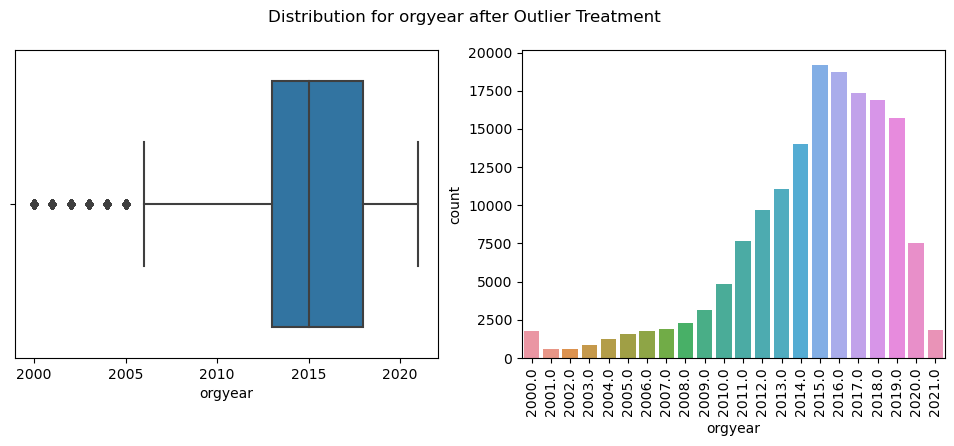

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
i = 0

sns.boxplot(x=df_clean2['orgyear'], ax=axs[0])
sns.countplot(x=df_clean2['orgyear'], ax=axs[1])
axs[1].tick_params(axis='x', rotation=90) 

plt.suptitle(f'Distribution for orgyear after Outlier Treatment')
plt.show()

### **Outlier Treatment: ctc**

In [59]:
df_clean2['ctc'].describe()

count    1.603040e+05
mean     2.471383e+06
std      1.285101e+07
min      2.000000e+00
25%      5.500000e+05
50%      9.750000e+05
75%      1.700000e+06
max      1.000150e+09
Name: ctc, dtype: float64

In [60]:
# Using 1.5*IQR
iqr = df_clean2['ctc'].quantile(0.75)-df_clean2['ctc'].quantile(0.25)
Lower_whisker = df_clean2['ctc'].quantile(0.25) - 1.5*iqr
Upper_whisker = df_clean2['ctc'].quantile(0.75) + 1.5*iqr

print(f'Lower_whisker: {Lower_whisker}')
print(f'Upper_whisker: {Upper_whisker}')

Lower_whisker: -1175000.0
Upper_whisker: 3425000.0


In [61]:
for i in range(11):
    print(f'{round(10*i*0.01, 3)} percentile of ctc:', df_clean2['ctc'].quantile(i*0.01))

0.0 percentile of ctc: 2.0
0.1 percentile of ctc: 38000.0
0.2 percentile of ctc: 80000.0
0.3 percentile of ctc: 100000.0
0.4 percentile of ctc: 140000.0
0.5 percentile of ctc: 200000.0
0.6 percentile of ctc: 202000.0
0.7 percentile of ctc: 260000.0
0.8 percentile of ctc: 300000.0
0.9 percentile of ctc: 300000.0
1.0 percentile of ctc: 336000.0


In [62]:
for i in range(10):
    print(f'{round(98 + 100*i*0.002, 3)} percentile of ctc:', df_clean2['ctc'].quantile(0.98 + i*0.002))

98.0 percentile of ctc: 6850000.0
98.2 percentile of ctc: 7500000.0
98.4 percentile of ctc: 8500000.0
98.6 percentile of ctc: 10000000.0
98.8 percentile of ctc: 12000000.0
99.0 percentile of ctc: 20000000.0
99.2 percentile of ctc: 60000000.0
99.4 percentile of ctc: 100000000.0
99.6 percentile of ctc: 100000000.0
99.8 percentile of ctc: 200000000.0


We will use capping to treat the outliers:
- Cap the values below 1st percentile with value at 1st percentile
- Cap the values above 99th percentile with value at 99th percentile

In [63]:
def out_trt_ctc(yr):
    if yr < 336000:
        return 336000
    elif yr > 20000000:
        return 20000000
    return yr

df_clean2['ctc'] = df_clean2['ctc'].apply(lambda x: out_trt_ctc(x))

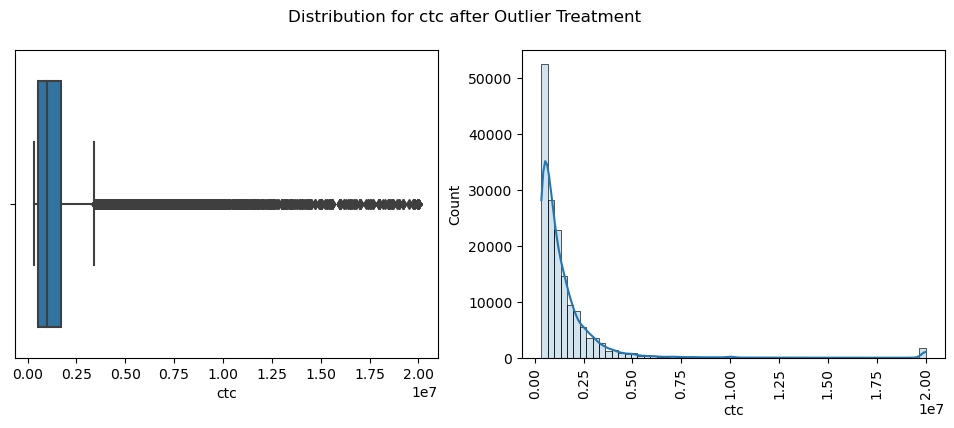

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
i = 0

sns.boxplot(x=df_clean2['ctc'], ax=axs[0])
sns.histplot(x=df_clean2['ctc'], ax=axs[1], bins=60, kde=True, alpha=0.2)
axs[1].tick_params(axis='x', rotation=90) 

plt.suptitle(f'Distribution for ctc after Outlier Treatment')
plt.show()

## **Treatment of Categorical Columns**

- Here we will explore the various categories inside each categorical feature and  do some data cleaning if required

### **Treatment: company_hash**

In [65]:
df_clean2['company_hash'].describe()

count                        160304
unique                        37299
top       nvnv wgzohrnvzwj otqcxwto
freq                           5469
Name: company_hash, dtype: object

In [66]:
ser_company = df_clean2['company_hash'].value_counts()
print(f'#Companies with more than 1 record: {ser_company.loc[ser_company>=2].shape[0]}')

#Companies with more than 1 record: 9012


In [67]:
# Checking for empty strings as company_hash
(df_clean2['company_hash']=='').sum()

0

### **Treatment: email_hash**

In [68]:
df_clean2['email_hash'].describe()

count                                                160304
unique                                               153443
top       db84980ad197f8eff08b14a3442ff57f6374ea780f2587...
freq                                                      3
Name: email_hash, dtype: object

In [69]:
ser_email = df_clean2['email_hash'].value_counts()
print(f'#Learners with more than 1 record: {ser_email.loc[ser_email>=2].shape[0]}')
print(f'Max records against a single learner: {ser_email.max()}')

#Learners with more than 1 record: 6860
Max records against a single learner: 3


In [70]:
# Checking for empty strings as email_hash
(df_clean2['email_hash']=='').sum()

0

### **Treatment: job_position**

In [71]:
df_clean2['job_position'].describe()

count               136398
unique                 867
top       Backend Engineer
freq                 39053
Name: job_position, dtype: object

In [72]:
ser_job = df_clean2['job_position'].value_counts()
print(f'Total records of job_position: {df_clean2["job_position"].shape[0]}')
print(f'#Records with missing job: {df_clean2["job_position"].isna().sum()}')
print('-'*50)
print(f'Unique #jobs: {ser_job.shape[0]}')
print(f'#Jobs with more than 1 record: {ser_job.loc[ser_job>=2].shape[0]}')
print(f'#Jobs with only 1 record: {867-ser_job.loc[ser_job>=2].shape[0]}')
print(f'Max records against a single job: {ser_job.max()}')

Total records of job_position: 160304
#Records with missing job: 23906
--------------------------------------------------
Unique #jobs: 867
#Jobs with more than 1 record: 202
#Jobs with only 1 record: 665
Max records against a single job: 39053


In [73]:
non_null_jds = df_clean2.loc[~df_clean2['job_position'].isna(), 'job_position']
non_null_jds

0           Backend Engineer
1           Backend Engineer
2         FullStack Engineer
4          Frontend Engineer
5          Frontend Engineer
                 ...        
160299    FullStack Engineer
160300    FullStack Engineer
160301     Frontend Engineer
160302    Engineering Intern
160303      Backend Engineer
Name: job_position, Length: 136398, dtype: object

#### **Approach**

We wish to go through the different jobs and explore the option of grouping similar jobs manually. The approaches used are as follows:
- converting all strings to lower case, and using string functions like split(), strip()
- converting roman numbers in job designations to decimal numbers (ed: 'SDE II' to 'SDE 2')
- using Levenshtein distance to group similar strings and manually examining groups to clean further

#### **Simple cleaning using lower(), split(), strip()**

In [74]:
non_null_jds_sc = non_null_jds.apply(lambda x: (' ').join([item.strip(' ()-')for item in x.lower().split()]))
non_null_jds_sc

0           backend engineer
1           backend engineer
2         fullstack engineer
4          frontend engineer
5          frontend engineer
                 ...        
160299    fullstack engineer
160300    fullstack engineer
160301     frontend engineer
160302    engineering intern
160303      backend engineer
Name: job_position, Length: 136398, dtype: object

In [75]:
# jds = []
# for val in non_null_jds.apply(lambda x: (' ').join([item.strip(' ()-') for item in x.lower().split()])).values:
#     jds.append(val)
    
# jds = np.array(jds)
# np.unique(jds)

#### **Converting roman numbers to decimal numbers**

In [76]:
def roman_handling(word_lst):
    lookup_d = {'i': '1', 'ii': '2', 'iii': '3', 'iv': '4', 'v': '5'}
    for key in lookup_d:
        if key in word_lst:
            idx = word_lst.index(key)
            word_lst[idx] = lookup_d[key]
    return (' ').join(word_lst)

            
# roman_handling('software engineer iii'.split())        

In [77]:
non_null_jds_rh = non_null_jds_sc.apply(lambda x: roman_handling(x.split()))
non_null_jds_rh

0           backend engineer
1           backend engineer
2         fullstack engineer
4          frontend engineer
5          frontend engineer
                 ...        
160299    fullstack engineer
160300    fullstack engineer
160301     frontend engineer
160302    engineering intern
160303      backend engineer
Name: job_position, Length: 136398, dtype: object

In [78]:
# jd_rh = []
# for val in non_null_jds_rh.values:
#     jd_rh.append(val)

# jd_rh = np.array(jd_rh)
# np.unique(jd_rh)

In [79]:
# Removing some spaces that were not removed earlier 
non_null_jds_rh = non_null_jds_rh.apply(lambda x: (' ').join(x.split()))
non_null_jds_rh

0           backend engineer
1           backend engineer
2         fullstack engineer
4          frontend engineer
5          frontend engineer
                 ...        
160299    fullstack engineer
160300    fullstack engineer
160301     frontend engineer
160302    engineering intern
160303      backend engineer
Name: job_position, Length: 136398, dtype: object

#### **Using Levenshtein distance to group similar strings**

In [80]:
xx = np.unique(non_null_jds_rh)
xx_copy = set()

print('Pre-Run')
print(len(xx), len(xx_copy))

similar_d = {}
for i in range(len(xx)):
    if xx[i] not in xx_copy:
        xx_copy.add(xx[i])
        matches = [xx[i]]
        for j in range(i+1, len(xx)):
            if (xx[j] not in xx_copy) and (fuzz.ratio(xx[i], xx[j])>=80):
                xx_copy.add(xx[j])
                matches.append(xx[j])
        
        similar_d[xx[i]] = matches   
        
print('Post-Run')
print(len(xx), len(xx_copy))

Pre-Run
763 0
Post-Run
763 763


#### **Manual grouping using grops created by Levenshtein distance**

In [81]:
# Unique group lengths (here groups refer to those created by Lev_distance) 
np.unique(np.array([len(similar_d[key]) for key in similar_d]))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11])

In [82]:
def jd_raw_clean(jd):
    clean_d = {
        'software engineer' : ['software enginner', 'softwear engineer', 'java software engineer', 'cloud software engineer', 'software engineering', 
                               'analyst / software engineer', 'software eng', 'software', 'software engineer r&d', 'software engineering co-op', 
                               'software engineer 1'],
        'software engineer 2' : ['software engineer 2b', 'software engineer l2'],
        'software engineer 3' : ['software engineer 4', 'software engineer 3 sde2'],
        'lead software engineer' : ['tech lead software engineer', 'senior software engineer lead', 'software engineering lead', 
                                    'sr lead engineer', 'lead engineer 2'],

        
        
        'senior software engineer' : ['sr software engineer', 'sr. software engineer', 'senior software engineeer', 'seniorsoftwareengineer', 
                                      'senior software engineer-l2', 'sr software engg'],
        'junior software engineer' : ['jr. software engineer'],
        
        'associate software developer' : ['associate developer'],
        'software developer' : ['software devloper', 'graduate software developer', 'junior developer', 'software development', 'software developer 1'],
        'senior software developer' : ['sr. developer', 'senior developer', 'executive software developer'],
        

        
        
        'senior software development engineer' : ['senior software development enggineer'],      
        'software development engineer 1' : ['software development enginner', 'sde 1', 'sde-1', 'sde-i', 'software dev. engineer'],
        'software development engineer 2' : ['senior software development engineer 2', 'sde 2', 'sde-2', 'sde2', 'sde-ii', 'sdeii'],
        'software development engineer 3' : ['sde 3', 'sde-3', 'sde 4', 'software developer sde-3', 'sde3'],
        
        
        'software engineer testing' : ['software engineer in test', 'software test engineer'],
        'software engineer testing 2' : ['sdet-2', 'senior software test engineer', 'senior software development engineer in test', 'sdet 3'],
        'lead software engineer testing' : ['lead software engineer in test', 'technical test lead'],
        'automation test engineer' : ['automation test enginner', 'test automation engineer', 'automation engineer'],
        
        'backend engineer' : ['software engineer backend', 'backend engineering'],
        'senior backend engineer' : ['senior software engineer backend', 'senior software development engineer backend', 'software engineer 2 backend', 
                                              'senior software engineer .net backend'],
        
        'frontend engineer' : ['front end engineer', 'front end web developer', 'front-end developer', 'front end dev', 'front end developer', 
                               'software engineer frontend'],
        'senior frontend engineer' : ['senior software engineer front end', 'senior front end engineer', 'senior frontend developer'],
        
        
        'fullstack engineer' : ['full stack engineer', 'full-stack web developer', 'full stack devloper', 'full stack web developer', 'software engineer full stack', 
                                'software engineer 2 full stack' ],
 
        
        
                
        'web developer' : ['junior web developer', 'senior web developer', 'software / web developer', 'software developer ui'],
        'senior android developer' : ['sr software engg android'],
        
        
        
        'software developer intern' : ['intern software developer', 'software development intern'],
        'software engineering intern' : ['software engineering intern', 'software engineer(r&d intern'],
        'intern' : ['qa intern', 'sde intern', 'student intern', 'sdet intern'],
        'machine learning engineer intern' : ['machine learning intern'],
        'trainee' : ['it trainee', 'assistant engineer trainee'],
        
        
        
        
        
        
        'consultant' : ['consultanat', 'technical consultant', 'technology consultant', 'technical consulting', 'software consultant'],       
        'senior consultant' : ['sr consultant', 'senior software consultant', 'senior consulant'],
        'manager' : ['asst. manager', 'tech manager', 'team manager', 'it mmanager', 'audit manager', 'manager-cx', 'sr. technical manager', 
                     'technical manager', 'senior manager', 'senior manager it'],
        'executive' : ['sr. executive', 'pdp executive', 'it executive', 'sr. mis executive', 'sr hr executive'],
        
    

        
        'engineering leadership' : ['engineering lead ai', 'engineering team lead'],        
        'member of technical staff' : ['member technical staff', 'member of technical staff java', 'member technial staff'],
        'principal member of technical staff' : ['principle member of technical staff'],
        'technical lead' : ['technical leader', 'tecchnical lead', 'technical head'],
 
        
        
        'research engineer' : ['r&d engineer', 'research engineers', 'reasearch engineer', 'research engineer 2', 'rd engineer 2'],
        'research analyst' : ['reseach analyst'],
        'research assistant' : ['graduate research assistant'],
        
        
        
        
        'qa engineer' : ['software qa engineer', 'software qa'],
        'programmer analyst' : ['pragrammer analyst', 'programmar analyst', 'programmer analyst 2', 'software engineering analyst', 
                                'software engineer analyst', 'software development analyst', 'senior software analyst', 'senior analyst programmer', 
                                'analyst programmer'], 
        'programmer analyst trainee' : ['program analyst trainee'],
        
        

        
        
        'engineer' : ['engineer 1', 'engineet', 'technical engineer'],
        'embedded software engineer' : ['embedded software development engineer'],           
        'assistant system engineer' : ['assisatnt system engineer', 'assistant system enginner'],
        'application development associate' : ['application developmentaassociate'],
        'technical associate' : ['associate l1', 'technology associate', 'technical associate'],

        


        'other' : ['others', 'pa', 'pat', 'eno', 'no'],
        'operation executive': ['sr. operation executive'] ,   
        'oracle administrator' : ['oracle dba', 'oracle lead dba'],   
        'solution architect' : ['sr solution architect'],
        'senior analyst': ['senior analysts', 'senior lead analyst', 'senior business operations analyst', 'senior business analyst'],
        'senior associate': ['senior chat associate'],
        'senior associate platform' : ['sr. associate platform'],       
        'specialist programmer' : ['specialist programmer pp'],
        'technical architect' : ['technical architecct', 'sr technical architect', 'sr. technical architect'],
        'mts' : ['smts', 'mts2'],
        
 
        'data engineer' : ['data eingineer', 'associate data engineer'],
        'mechanical engineer' : ['mechanical engineers'],
        'associate application developer' : ['associate applications developer'],
        'application engineer 2' : ['applications engineer 2'],        
        
        'co-founder' : ['co-founderg'],
        'associate technical lead' : ['associate tech lead'],
        'associate system engineer trainee' : ['associate system engineer-trainee'],
        'associate processor' : ['associate professor'],
        
        'business analyst' : ['business analysts', 'ba', 'bda'], 
        'technology analyst' : ['business technology analyst', 'bta'], 
        'security analyst' : ['cloud security analyst'],
        'digital marketing' : ['digital marketing manager'],
        'developer associate' : ['developer asociate'],
        'entrepreneur' : ['entrepreneurship'],
        'product developer': ['product develloper'],
        'project lead' : ['project leader'],
        'talent acquisition specialist': ['talent acquisition sspecialist'],
        'vice president' : ['voice president'],
        'web designer' : ['web / ui designer']
        
        

        # To check: trianee, intern, android, ios, backend, frontend, fullstack, web, mobile, analyst
          
        
    }
    
    for key in clean_d:
        if jd in clean_d[key]:
            return key
    
    return jd

# clean_jd('software enginner')
non_null_jds_rh_rc = non_null_jds_rh.apply(lambda x: jd_raw_clean(x))

In [83]:
# len(similar_d[key]) : [10, )

# for key in similar_d:
#     if len(similar_d[key])>=10:
#         print(f'{key}: {similar_d[key]}')
#         print('~'*50)
#         print(non_null_jds_rh.loc[(non_null_jds_rh.isin(similar_d[key]))].value_counts())
#         print('-'*150)

# -------- XX -------- || -------- XX -------- || -------- XX -------- || -------- XX --------
        
# len(similar_d[key]) : [7-10)

# for key in similar_d:
#     if len(similar_d[key])>=7 and len(similar_d[key])<10:
#         print(f'{key}: {similar_d[key]}')
#         print('~'*50)
#         print(non_null_jds_rh.loc[(non_null_jds_rh.isin(similar_d[key]))].value_counts())
#         print('-'*50)

# -------- XX -------- || -------- XX -------- || -------- XX -------- || -------- XX --------

# len(similar_d[key]) : [4-7)

# for key in similar_d:
#     if len(similar_d[key])>=4 and len(similar_d[key])<7:
#         print(f'{key}: {similar_d[key]}')
#         print('~'*50)
#         print(non_null_jds_rh.loc[(non_null_jds_rh.isin(similar_d[key]))].value_counts())
#         print('-'*50)

# -------- XX -------- || -------- XX -------- || -------- XX -------- || -------- XX --------

# len(similar_d[key]) : [2-4)

# for key in similar_d:
#     if len(similar_d[key])>=2 and len(similar_d[key])<4:
#         # print(f'{key}: {similar_d[key]}')
#         # print('~'*50)
#         print(non_null_jds_rh.loc[(non_null_jds_rh.isin(similar_d[key]))].value_counts())
#         print('-'*50)

        
# -------- XX -------- || -------- XX -------- || -------- XX -------- || -------- XX --------

# len(similar_d[key]) : [2-4)

# count = 0
# for key in similar_d:
#     # if len(similar_d[key])==1:
#     #     print(f'{key}: {similar_d[key]}')
#     #     print('~'*50)
#     #     print(non_null_jds_rh.loc[(non_null_jds_rh.isin(similar_d[key]))].value_counts())
#     #     print('-'*50)
#         count += 1
# print(count)

In [84]:
ser_job_rh_rc = non_null_jds_rh_rc.value_counts()

In [85]:
print(f'Total records of job_position: {df_clean2["job_position"].shape[0]}')
print(f'#Records with missing job: {df_clean2["job_position"].isna().sum()}')
print(f'% of Records with missing job: {round(100*df_clean2["job_position"].isna().sum()/df_clean2["job_position"].shape[0], 2)}%')
print(f'#Records with non-null jobs: {(~df_clean2["job_position"].isna()).sum()}')
print(f'% of Records with missing job: {round(100*(~df_clean2["job_position"].isna()).sum()/df_clean2["job_position"].shape[0], 2)}%')
print('-'*50)
print(f'Unique #jobs: {ser_job_rh_rc.shape[0]}')
print(f'#Jobs with more than 1 record: {ser_job_rh_rc.loc[ser_job_rh_rc>=2].shape[0]}')
print(f'#Jobs with only 1 record: {576-ser_job_rh_rc.loc[ser_job_rh_rc>=2].shape[0]}')
print(f'Max records against a single job: {ser_job_rh_rc.max()}')

Total records of job_position: 160304
#Records with missing job: 23906
% of Records with missing job: 14.91%
#Records with non-null jobs: 136398
% of Records with missing job: 85.09%
--------------------------------------------------
Unique #jobs: 575
#Jobs with more than 1 record: 173
#Jobs with only 1 record: 403
Max records against a single job: 39085


In [86]:
# Top 25 job descriptions
df_top50_jds = pd.DataFrame(ser_job_rh_rc.iloc[:25])
df_top50_jds['count'] = df_top50_jds['job_position']
df_top50_jds.drop('job_position', axis=1, inplace=True)
df_top50_jds['count_pct'] = 100*df_top50_jds['count']/df_clean2.shape[0]
df_top50_jds['count_cumsum'] = df_top50_jds['count'].cumsum()
df_top50_jds['count_cumsum_pct'] = 100*df_top50_jds['count_cumsum']/df_clean2.shape[0]
df_top50_jds

count  count_pct  count_cumsum  count_cumsum_pct
backend engineer          39085  24.381800         39085         24.381800
fullstack engineer        22419  13.985303         61504         38.367103
other                     14587   9.099586         76091         47.466688
frontend engineer          9581   5.976769         85672         53.443457
engineering leadership     6316   3.940014         91988         57.383471
qa engineer                6232   3.887614         98220         61.271085
data scientist             5042   3.145274        103262         64.416359
android engineer           5029   3.137164        108291         67.553523
sdet                       4567   2.848962        112858         70.402485
devops engineer            4385   2.735428        117243         73.137913
support engineer           3263   2.035508        120506         75.173421
data analyst               2666   1.663090        123172         76.836511
ios engineer               2624   1.636890        125796         78.473401
engineering intern         2202   1.373640        127998         79.847041
product designer           1283   0.800354        129281         80.647395
product manager            1096   0.683701        130377         81.331096
backend architect          1086   0.677463        131463         82.008559
research engineer          1060   0.661244        132523         82.669802
program manager             778   0.485328        133301         83.155130
non coder                   560   0.349336        133861         83.504467
database administrator      523   0.326255        134384         83.830722
co-founder                  342   0.213345        134726         84.044066
security leadership         142   0.088582        134868         84.132648
release engineer            119   0.074234        134987         84.206882
senior software engineer     60   0.037429        135047         84.244311

**After manual cleaning of the categories in job_position, we have the below observations:**

- There are 160304 records out of which missing records (23906) are ~15% (that is non-missing records (136398) account for 85%)
- There are 576 unique jobs and out of these 576 jobs, we show the top 25 most occuring job positions in the above dataframe
- The key observation is that the top 25 jobs account for 135047 records (which account for 84% of total records)
- This implies that all the other jobs except the top 25 jobs account for only (136398-135047)=1351 records accounting for only 1% of total records
- Given this insight we can go ahead an re-catogorize those jobs with freq<=5 as 'other'

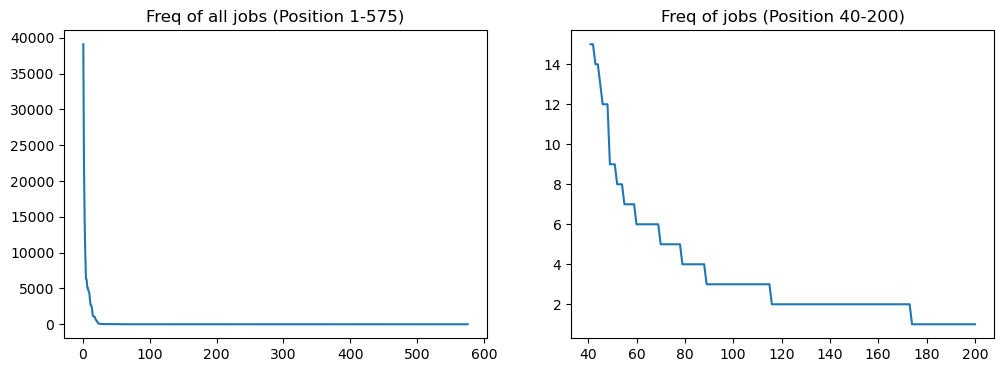

In [87]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
len_job_rh_rc = ser_job_rh_rc.shape[0]

axs[0].plot(np.linspace(1, len_job_rh_rc, len_job_rh_rc), ser_job_rh_rc.values)
axs[0].set_title(f'Freq of all jobs (Position 1-{len_job_rh_rc})')
axs[1].plot(np.linspace(1, len_job_rh_rc, len_job_rh_rc)[40:200], ser_job_rh_rc.values[40:200])
axs[1].set_title('Freq of jobs (Position 40-200)')

plt.show()

#### **Re-categorizing jobs with frequency<=5 as 'other'**

In [88]:
df_clean3 = df_clean2.copy()
df_clean3['job_position_cln'] = non_null_jds_rh_rc

In [89]:
jobs_freq_upto5 = ser_job_rh_rc.loc[ser_job_rh_rc<=5].index
jobs_freq_upto5

Index(['automation test engineer', 'principal software engineer',
       'research assistant', 'na', 'product developer', 'executive',
       'programmer analyst trainee', 'assistant manager', 'web developer',
       'vice president',
       ...
       'professional services engineer', 'associate data scientist',
       'sap cpq consultant', 'back office executive admin',
       'chief people officer', 'computer scientist 2',
       'student in computer application', 'delivery project lead',
       'associate futures engineering team', 'subject matter expert'],
      dtype='object', length=506)

In [90]:
df_clean3.loc[df_clean3['job_position_cln'].isin(jobs_freq_upto5), 'job_position_cln'] = 'other'
df_clean3.drop('job_position', axis=1, inplace=True)
df_clean3['job_position_cln'].describe()

count               136398
unique                  69
top       backend engineer
freq                 39085
Name: job_position_cln, dtype: object

## **KNN Imputation of job_position**

In [91]:
# df_clean2.isna().sum()

In [92]:
df_clean3.isna().sum()

email_hash              0
company_hash            0
orgyear                 0
ctc_updated_year        0
ctc                     0
job_position_cln    23906
dtype: int64

In [93]:
# df_clean4 = df_clean2.copy()
df_clean4 = df_clean3.copy()

le = LabelEncoder()
df_clean4['company_hash_encode'] = le.fit_transform(df_clean4['company_hash'])
df_clean4['job_position_cln'].fillna('missing', inplace=True)
df_clean4['job_position_cln_encode'] = le.fit_transform(df_clean4['job_position_cln'])

In [94]:
df_clean4.loc[df_clean4['job_position_cln']=='missing'].head()

email_hash  \
3   00014d71a389170e668ba96ae8e1f9d991591acc899025...   
6   000411b5d6d4e1c113bf83f1eebc0b835d77cc45bded1d...   
15  000a028ed6fe3c5a2ebdcdf67b8d4f7785821b51113565...   
20  000c89400932b5cc8a3d6c5b6a854c844f0f64a53d7b8a...   
22  000dbb08ff8c14f7c6d4729e0d9015c48cc57c6de27cf2...   

                      company_hash  orgyear  ctc_updated_year      ctc  \
3                     fvrbvqn rvmo   2009.0            2018.0  3400000   
6                          gutzcgj   2017.0            2021.0  3500000   
15    vhnymqxast qtotvqwy otqcxwto   2016.0            2020.0   360000   
20                        evwtmggp   2015.0            2016.0  2100000   
22  bxwqgogen qa xzaxv uqxcvnt rna   2011.0            2015.0  1650000   

   job_position_cln  company_hash_encode  job_position_cln_encode  
3           missing                 7022                       29  
6           missing                 7914                       29  
15          missing                26987                       29  
20          missing                 6118                       29  
22          missing                 3808                       29

In [95]:
df_clean4.loc[df_clean4['job_position_cln']=='missing', 'job_position_cln_encode']=np.nan
df_clean4.loc[df_clean4['job_position_cln']=='missing'].head()

email_hash  \
3   00014d71a389170e668ba96ae8e1f9d991591acc899025...   
6   000411b5d6d4e1c113bf83f1eebc0b835d77cc45bded1d...   
15  000a028ed6fe3c5a2ebdcdf67b8d4f7785821b51113565...   
20  000c89400932b5cc8a3d6c5b6a854c844f0f64a53d7b8a...   
22  000dbb08ff8c14f7c6d4729e0d9015c48cc57c6de27cf2...   

                      company_hash  orgyear  ctc_updated_year      ctc  \
3                     fvrbvqn rvmo   2009.0            2018.0  3400000   
6                          gutzcgj   2017.0            2021.0  3500000   
15    vhnymqxast qtotvqwy otqcxwto   2016.0            2020.0   360000   
20                        evwtmggp   2015.0            2016.0  2100000   
22  bxwqgogen qa xzaxv uqxcvnt rna   2011.0            2015.0  1650000   

   job_position_cln  company_hash_encode  job_position_cln_encode  
3           missing                 7022                      NaN  
6           missing                 7914                      NaN  
15          missing                26987                      NaN  
20          missing                 6118                      NaN  
22          missing                 3808                      NaN

In [96]:
std_scaler = StandardScaler()
X_clean4 = std_scaler.fit_transform(df_clean4[['company_hash_encode', 'job_position_cln_encode', 'orgyear', 'ctc_updated_year', 'ctc']])

In [97]:
knn_imputer = KNNImputer(n_neighbors=1, weights='uniform')
X_clean_knn4 = knn_imputer.fit_transform(X_clean4)

In [98]:
x_job_pos_cln_enc_knn_unscaled = std_scaler.inverse_transform(X_clean_knn4)[:, 1]
x_job_pos_cln_enc_knn_unscaled = np.array(x_job_pos_cln_enc_knn_unscaled, dtype='int64')

In [99]:
df_clean4['job_position'] = le.inverse_transform(x_job_pos_cln_enc_knn_unscaled)
df_clean4.drop(['job_position_cln', 'company_hash_encode', 'job_position_cln_encode'], axis=1, inplace=True)
df_clean4.head()

email_hash           company_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...              bxwqgogen   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...           nqsn axsxnvr   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...  bxwqgotbx wgqugqvnxgz   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...           fvrbvqn rvmo   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...              vqtkkgopj   

   orgyear  ctc_updated_year      ctc        job_position  
0   2012.0            2019.0  3500000    backend engineer  
1   2013.0            2020.0   336000    backend engineer  
2   2004.0            2021.0  2000000  fullstack engineer  
3   2009.0            2018.0  3400000  fullstack engineer  
4   2016.0            2020.0   750000   frontend engineer

In [100]:
df_clean4.isna().sum()

email_hash          0
company_hash        0
orgyear             0
ctc_updated_year    0
ctc                 0
job_position        0
dtype: int64

In [101]:
(df_clean4['job_position']=='missing').sum()

0

# **Feature Engineering1: Manual Clustering**

## **Years of Experience in current company & current job (yoe):**

In [102]:
df_final = df_clean4.copy()
df_final['yoe'] = 2024-df_final['orgyear']
df_final.drop(['orgyear'], axis=1, inplace=True)
df_final = df_final.iloc[:, [0, 1, 4, 5, 2, 3]]
df_final.head()

email_hash           company_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...              bxwqgogen   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...           nqsn axsxnvr   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...  bxwqgotbx wgqugqvnxgz   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...           fvrbvqn rvmo   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...              vqtkkgopj   

         job_position   yoe  ctc_updated_year      ctc  
0    backend engineer  12.0            2019.0  3500000  
1    backend engineer  11.0            2020.0   336000  
2  fullstack engineer  20.0            2021.0  2000000  
3  fullstack engineer  15.0            2018.0  3400000  
4   frontend engineer   8.0            2020.0   750000

## **Designation:**
- How much does leaner earn compared to other learners in same company, in same job and with same yoe?
- Will bucketize learners into 3 buckets (1 denoting high earners and 3 denoting low earners)

In [103]:
df_grp_comp_job_yoe = df_final.groupby(['company_hash', 'job_position', 'yoe'])[['ctc']].describe()
df_grp_comp_job_yoe.columns = [('_').join(tup) for tup in df_grp_comp_job_yoe.columns]
df_grp_comp_job_yoe = df_grp_comp_job_yoe.reset_index()
df_grp_comp_job_yoe.rename(columns={'ctc_count':'grp_count'}, inplace=True)
df_grp_comp_job_yoe.head()

company_hash       job_position   yoe  grp_count  \
0                               0              other   4.0        1.0   
1                            0000              other   7.0        1.0   
2                      01 ojztqsj   android engineer   8.0        1.0   
3                      01 ojztqsj  frontend engineer  13.0        1.0   
4  05mz exzytvrny uqxcvnt rxbxnta   backend engineer   5.0        1.0   

    ctc_mean  ctc_std    ctc_min    ctc_25%    ctc_50%    ctc_75%    ctc_max  
0   336000.0      NaN   336000.0   336000.0   336000.0   336000.0   336000.0  
1   336000.0      NaN   336000.0   336000.0   336000.0   336000.0   336000.0  
2   336000.0      NaN   336000.0   336000.0   336000.0   336000.0   336000.0  
3   830000.0      NaN   830000.0   830000.0   830000.0   830000.0   830000.0  
4  1100000.0      NaN  1100000.0  1100000.0  1100000.0  1100000.0  1100000.0

In [104]:
# df_grp_comp_job_yoe['grp_count'].value_counts()

In [105]:
# sns.histplot(df_grp_comp_job_yoe['grp_count'].value_counts().index, bins=20)
# plt.show()

### *Checking percentile ratios 75p/50p & 50p/25p to understand skewness of groups created*

In [106]:
df_grp_comp_job_yoe['ctc_75p_50p_r'] = df_grp_comp_job_yoe['ctc_75%']/df_grp_comp_job_yoe['ctc_50%']
df_grp_comp_job_yoe['ctc_50p_25p_r'] = df_grp_comp_job_yoe['ctc_50%']/df_grp_comp_job_yoe['ctc_25%']
df_grp_comp_job_yoe.loc[df_grp_comp_job_yoe['grp_count']>5, ['ctc_50p_25p_r', 'ctc_75p_50p_r']].describe()

ctc_50p_25p_r  ctc_75p_50p_r
count    2725.000000    2725.000000
mean        1.340348       1.395893
std         0.493833       1.119090
min         1.000000       1.000000
25%         1.109890       1.125000
50%         1.217647       1.243636
75%         1.413043       1.438849
max        10.416667      36.363636

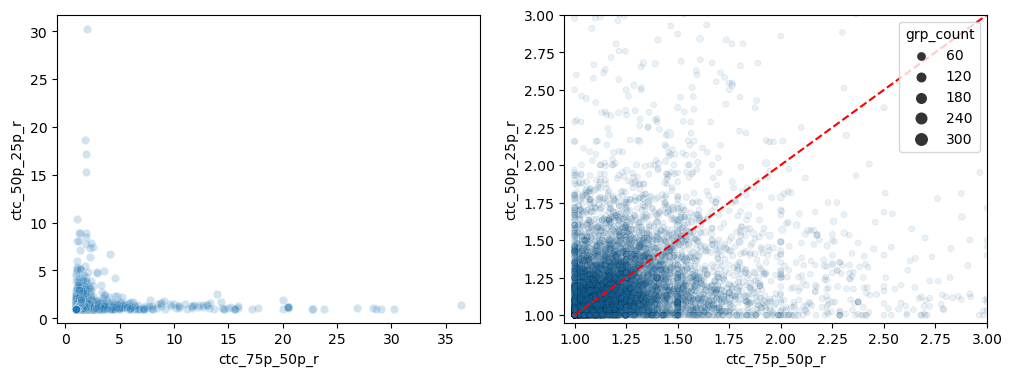

In [107]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.scatterplot(x=df_grp_comp_job_yoe['ctc_75p_50p_r'], y=df_grp_comp_job_yoe['ctc_50p_25p_r'], alpha=0.2, ax=axs[0])
# axs[0].set_xlim(left=0.95, right=3)
# axs[0].set_ylim(bottom=0.95, top=3)


df_grp_comp_job_yoe_tmp = df_grp_comp_job_yoe.loc[df_grp_comp_job_yoe['grp_count']>2]

sns.scatterplot(x=df_grp_comp_job_yoe_tmp['ctc_75p_50p_r'], y=df_grp_comp_job_yoe_tmp['ctc_50p_25p_r'], alpha=0.1, 
                size=df_grp_comp_job_yoe_tmp['grp_count'], edgecolor='black', ax=axs[1])
axs[1].set_xlim(left=0.95, right=3)
axs[1].set_ylim(bottom=0.95, top=3)
axs[1].plot(np.arange(1, 4), np.arange(1, 4), color='r', linestyle='--')

plt.show()

In [108]:
# Joining original dataset with 25p, 50p, 75p of created groups
df_grp_comp_job_yoe_merge = pd.merge(df_final, df_grp_comp_job_yoe.iloc[:, [0,1,2,7,8,9]], on=['company_hash', 'job_position', 'yoe'], how='left')
df_grp_comp_job_yoe_merge.head()

email_hash           company_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...              bxwqgogen   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...           nqsn axsxnvr   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...  bxwqgotbx wgqugqvnxgz   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...           fvrbvqn rvmo   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...              vqtkkgopj   

         job_position   yoe  ctc_updated_year      ctc    ctc_25%    ctc_50%  \
0    backend engineer  12.0            2019.0  3500000  2045000.0  2800000.0   
1    backend engineer  11.0            2020.0   336000   336000.0   336000.0   
2  fullstack engineer  20.0            2021.0  2000000  2000000.0  2000000.0   
3  fullstack engineer  15.0            2018.0  3400000  3625000.0  3850000.0   
4   frontend engineer   8.0            2020.0   750000   750000.0   750000.0   

     ctc_75%  
0  3500000.0  
1   336000.0  
2  2000000.0  
3  4075000.0  
4   750000.0

### *Logic for creating feature:*
- We create a feature called 'designation'
- We bucketize all the records into 3 possible buckets: [1, 2, 3]
    - 1: if ctc is more than the median_ctc of the group which the record belongs to by 10%
    - 3: if ctc is less than the median_ctc of the group which the record belongs to by 10%
    - 2: all other cases

In [109]:
def designation_logic(ctc, ctc_grp_median, ctc_grp_25p, ctc_grp_75p):
    if ctc > 1.1*ctc_grp_median:
        return 1
    elif ctc_grp_median > 1.1*ctc:
        return 3
    return 2
    
    # if ctc > ctc_grp_75p:
    #     return 1
    # elif ctc < ctc_grp_25p:
    #     return 3
    # return 2

df_grp_comp_job_yoe_merge['designation'] = df_grp_comp_job_yoe_merge[['ctc', 'ctc_50%', 
                                                                      'ctc_25%', 'ctc_75%']].apply(lambda x: 
                                                                                                    designation_logic(x[0],x[1],x[2],x[3]), axis=1)
df_grp_comp_job_yoe_merge['designation'].value_counts(normalize=True)

2    0.672959
1    0.167139
3    0.159902
Name: designation, dtype: float64

## **Class:**
- How much does leaner earn compared to other learners in same company and in same job?
- Will bucketize learners into 3 buckets (1 denoting high earners and 3 denoting low earners)

In [110]:
df_grp_comp_job = df_final.groupby(['company_hash', 'job_position'])[['ctc']].describe()
df_grp_comp_job.columns = [('_').join(tup) for tup in df_grp_comp_job.columns]
df_grp_comp_job = df_grp_comp_job.reset_index()
df_grp_comp_job.rename(columns={'ctc_count':'grp_count'}, inplace=True)
df_grp_comp_job.head()

company_hash       job_position  grp_count   ctc_mean  \
0                               0              other        1.0   336000.0   
1                            0000              other        1.0   336000.0   
2                      01 ojztqsj   android engineer        1.0   336000.0   
3                      01 ojztqsj  frontend engineer        1.0   830000.0   
4  05mz exzytvrny uqxcvnt rxbxnta   backend engineer        1.0  1100000.0   

   ctc_std    ctc_min    ctc_25%    ctc_50%    ctc_75%    ctc_max  
0      NaN   336000.0   336000.0   336000.0   336000.0   336000.0  
1      NaN   336000.0   336000.0   336000.0   336000.0   336000.0  
2      NaN   336000.0   336000.0   336000.0   336000.0   336000.0  
3      NaN   830000.0   830000.0   830000.0   830000.0   830000.0  
4      NaN  1100000.0  1100000.0  1100000.0  1100000.0  1100000.0

In [111]:
# df_grp_comp_job['grp_count'].value_counts()

In [112]:
# sns.histplot(df_grp_comp_job['grp_count'].value_counts().index, bins=50)
# plt.show()

In [113]:
df_grp_comp_job['ctc_75p_50p_r'] = df_grp_comp_job['ctc_75%']/df_grp_comp_job['ctc_50%']
df_grp_comp_job['ctc_50p_25p_r'] = df_grp_comp_job['ctc_50%']/df_grp_comp_job['ctc_25%']
df_grp_comp_job.loc[df_grp_comp_job['grp_count']>5, ['ctc_50p_25p_r', 'ctc_75p_50p_r']].describe()

ctc_50p_25p_r  ctc_75p_50p_r
count    3320.000000    3320.000000
mean        1.393012       1.451158
std         0.499166       1.183019
min         1.000000       1.000000
25%         1.154212       1.180288
50%         1.280000       1.312500
75%         1.476374       1.500000
max        10.416667      42.164804

### *Checking percentile ratios 75p/50p & 50p/25p to understand skewness of groups created*

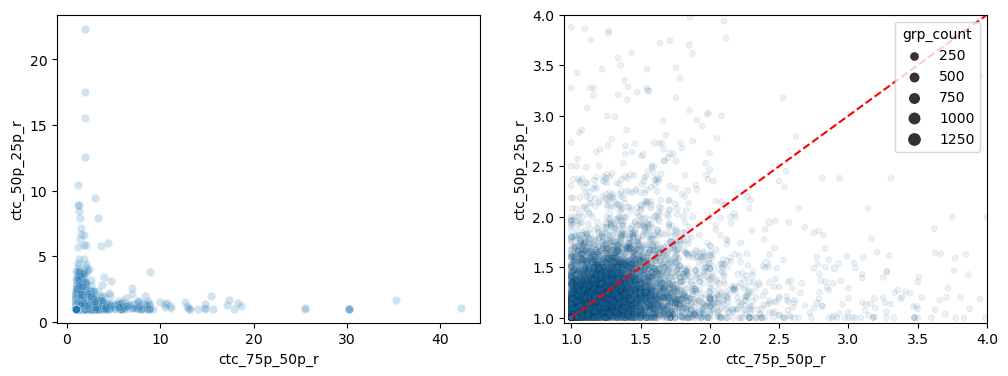

In [114]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.scatterplot(x=df_grp_comp_job['ctc_75p_50p_r'], y=df_grp_comp_job['ctc_50p_25p_r'], alpha=0.2, ax=axs[0])
# axs[0].set_xlim(left=0.95, right=3)
# axs[0].set_ylim(bottom=0.95, top=3)


df_grp_comp_job_tmp = df_grp_comp_job.loc[df_grp_comp_job['grp_count']>2]

sns.scatterplot(x=df_grp_comp_job_tmp['ctc_75p_50p_r'], y=df_grp_comp_job_tmp['ctc_50p_25p_r'], alpha=0.1, 
                size=df_grp_comp_job_tmp['grp_count'], edgecolor='black', ax=axs[1])
axs[1].set_xlim(left=0.95, right=4)
axs[1].set_ylim(bottom=0.95, top=4)
axs[1].plot(np.arange(1, 5), np.arange(1, 5), color='r', linestyle='--')

plt.show()

In [115]:
# Joining original dataset with 25p, 50p, 75p of created groups
df_grp_comp_job_merge = pd.merge(df_grp_comp_job_yoe_merge.drop(['ctc_50%','ctc_25%','ctc_75%'], axis=1), df_grp_comp_job.iloc[:, [0,1,6,7,8]], 
                                 on=['company_hash', 'job_position'], how='left')
df_grp_comp_job_merge.head()

email_hash           company_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...              bxwqgogen   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...           nqsn axsxnvr   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...  bxwqgotbx wgqugqvnxgz   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...           fvrbvqn rvmo   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...              vqtkkgopj   

         job_position   yoe  ctc_updated_year      ctc  designation  \
0    backend engineer  12.0            2019.0  3500000            1   
1    backend engineer  11.0            2020.0   336000            2   
2  fullstack engineer  20.0            2021.0  2000000            2   
3  fullstack engineer  15.0            2018.0  3400000            3   
4   frontend engineer   8.0            2020.0   750000            2   

     ctc_25%    ctc_50%    ctc_75%  
0  1900000.0  2510000.0  3600000.0  
1   336000.0   336000.0   336000.0  
2   752000.0  1168000.0  1584000.0  
3  1700000.0  2400000.0  3075000.0  
4   750000.0   750000.0   750000.0

### *Logic for creating feature:*
- We create a feature called 'class'
- We bucketize all the records into 3 possible buckets: [1, 2, 3]
    - 1: if ctc is more than the median_ctc of the group which the record belongs to by 10%
    - 3: if ctc is less than the median_ctc of the group which the record belongs to by 10%
    - 2: all other cases

In [116]:
def class_logic(ctc, ctc_grp_median, ctc_grp_25p, ctc_grp_75p):
    if ctc > 1.1*ctc_grp_median:
        return 1
    elif ctc_grp_median > 1.1*ctc:
        return 3
    return 2
    
    # if ctc > ctc_grp_75p:
    #     return 1
    # elif ctc < ctc_grp_25p:
    #     return 3
    # return 2

df_grp_comp_job_merge['class'] = df_grp_comp_job_merge[['ctc', 'ctc_50%', 
                                                        'ctc_25%', 'ctc_75%']].apply(lambda x: class_logic(x[0],x[1],x[2],x[3]), axis=1)
df_grp_comp_job_merge['class'].value_counts(normalize=True)

2    0.468903
1    0.268696
3    0.262401
Name: class, dtype: float64

In [117]:
df_grp_comp_job_merge[['designation', 'class']].apply(lambda x: f'{x[0]}_{x[1]}', axis=1).value_counts(normalize=True)

2_2    0.427949
1_1    0.138113
3_3    0.129392
2_3    0.125331
2_1    0.119679
1_2    0.021347
3_2    0.019606
3_1    0.010904
1_3    0.007679
dtype: float64

## **Tier:**
- How much does leaner earn compared to other learners in same company?
- Will bucketize learners into 3 buckets (1 denoting high earners and 3 denoting low earners)

In [118]:
df_grp_comp = df_final.groupby(['company_hash'])[['ctc', 'yoe']].describe()
df_grp_comp.columns = [('_').join(tup) for tup in df_grp_comp.columns]
df_grp_comp = df_grp_comp.reset_index()
df_grp_comp.head()

company_hash  ctc_count   ctc_mean        ctc_std  \
0                               0        1.0   336000.0            NaN   
1                            0000        1.0   336000.0            NaN   
2                      01 ojztqsj        2.0   583000.0  349310.749906   
3  05mz exzytvrny uqxcvnt rxbxnta        1.0  1100000.0            NaN   
4                               1        2.0   336000.0       0.000000   

     ctc_min    ctc_25%    ctc_50%    ctc_75%    ctc_max  yoe_count  yoe_mean  \
0   336000.0   336000.0   336000.0   336000.0   336000.0        1.0       4.0   
1   336000.0   336000.0   336000.0   336000.0   336000.0        1.0       7.0   
2   336000.0   459500.0   583000.0   706500.0   830000.0        2.0      10.5   
3  1100000.0  1100000.0  1100000.0  1100000.0  1100000.0        1.0       5.0   
4   336000.0   336000.0   336000.0   336000.0   336000.0        2.0       7.0   

    yoe_std  yoe_min  yoe_25%  yoe_50%  yoe_75%  yoe_max  
0       NaN      4.0     4.00      4.0     4.00      4.0  
1       NaN      7.0     7.00      7.0     7.00      7.0  
2  3.535534      8.0     9.25     10.5    11.75     13.0  
3       NaN      5.0     5.00      5.0     5.00      5.0  
4  0.000000      7.0     7.00      7.0     7.00      7.0

In [119]:
df_grp_comp_merge = pd.merge(df_grp_comp_job_merge.drop(['ctc_50%','ctc_25%','ctc_75%'], axis=1), df_grp_comp.iloc[:, [0, 5, 6, 7, 13, 14, 15]], 
                                 on=['company_hash'], how='left')
df_grp_comp_merge.head()

email_hash           company_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...              bxwqgogen   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...           nqsn axsxnvr   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...  bxwqgotbx wgqugqvnxgz   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...           fvrbvqn rvmo   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...              vqtkkgopj   

         job_position   yoe  ctc_updated_year      ctc  designation  class  \
0    backend engineer  12.0            2019.0  3500000            1      1   
1    backend engineer  11.0            2020.0   336000            2      2   
2  fullstack engineer  20.0            2021.0  2000000            2      1   
3  fullstack engineer  15.0            2018.0  3400000            3      1   
4   frontend engineer   8.0            2020.0   750000            2      2   

     ctc_25%    ctc_50%    ctc_75%  yoe_25%  yoe_50%  yoe_75%  
0  1697500.0  2500000.0  3500000.0      8.0     10.0     12.0  
1   336000.0   336000.0   336000.0     11.0     11.0     11.0  
2   950000.0  2000000.0  2280000.0      9.0     12.0     17.5  
3  1800000.0  2500000.0  3400000.0      8.0     10.0     12.0  
4   750000.0   750000.0   750000.0      8.0      8.0      8.0

### *Logic for creating feature:*
- We create a feature called 'tier'
- We bucketize all the records into 3 possible buckets: [1, 2, 3]
    - 1: if ctc is more than the median_ctc of the group which the record belongs to by 20%
    - 3: if ctc is less than the median_ctc of the group which the record belongs to by 20%
    - 2: all other cases

In [120]:
def tier_logic(ctc, ctc_grp_median, ctc_grp_25p, ctc_grp_75p):
    if ctc > 1.2*ctc_grp_median:
        return 1
    elif ctc_grp_median > 1.2*ctc:
        return 3
    return 2
    
    # if ctc > ctc_grp_75p:
    #     return 1
    # elif ctc < ctc_grp_25p:
    #     return 3
    # return 2

df_grp_comp_merge['tier'] = df_grp_comp_merge[['ctc', 'ctc_50%', 
                                                'ctc_25%', 'ctc_75%']].apply(lambda x: tier_logic(x[0],x[1],x[2],x[3]), axis=1)
df_grp_comp_merge['tier'].value_counts(normalize=True)

2    0.440195
1    0.285345
3    0.274460
Name: tier, dtype: float64

## **Checking distribution of records to each cluster:**
- For manual clustering, we designed 3 features (designation, class, tier)
- Each of the above features can be either 1 or 2 or 3
- Thus effectively we have split the entire dataset in any of the possible 27 groups (3X3X3)
- Below we show the #records per cluster as a % of the total records
- Top 5 clusters by size are the below ones (Designation-Class-Tier):
    - 2-2-2
    - 2-2-3
    - 2-2-1
    - 1-1-1
    - 3-3-3

In [121]:
df_final2 = df_grp_comp_merge.copy()
df_final2.drop(['ctc_25%', 'ctc_50%', 'ctc_75%', 'yoe_25%', 'yoe_50%', 'yoe_75%'], axis=1, inplace=True)
df_final2.head()

email_hash           company_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...              bxwqgogen   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...           nqsn axsxnvr   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...  bxwqgotbx wgqugqvnxgz   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...           fvrbvqn rvmo   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...              vqtkkgopj   

         job_position   yoe  ctc_updated_year      ctc  designation  class  \
0    backend engineer  12.0            2019.0  3500000            1      1   
1    backend engineer  11.0            2020.0   336000            2      2   
2  fullstack engineer  20.0            2021.0  2000000            2      1   
3  fullstack engineer  15.0            2018.0  3400000            3      1   
4   frontend engineer   8.0            2020.0   750000            2      2   

   tier  
0     1  
1     2  
2     2  
3     1  
4     2

In [122]:
df_final2[['designation', 'class', 'tier']].apply(lambda x: f'{x[0]}_{x[1]}_{x[2]}', axis=1).value_counts(normalize=True)

2_2_2    0.303947
1_1_1    0.115212
3_3_3    0.108300
2_1_1    0.088002
2_3_3    0.086704
2_2_3    0.062955
2_2_1    0.061047
2_3_2    0.032189
2_1_2    0.027922
1_1_2    0.020605
3_3_2    0.019251
1_2_2    0.015502
3_2_2    0.014030
3_1_1    0.006931
2_3_1    0.006438
1_3_3    0.004161
2_1_3    0.003755
3_1_2    0.003624
3_2_3    0.003312
1_2_1    0.003219
1_3_2    0.003125
1_2_3    0.002626
1_1_3    0.002296
3_2_1    0.002264
3_3_1    0.001840
1_3_1    0.000393
3_1_3    0.000349
dtype: float64

## **Insights from Manual Clustering:**

### *Top 10 employees (earning more than most of the employees in the company)*

In [123]:
df_final2_top10_emp_by_tier = df_final2.loc[df_final2['tier']==1, ['email_hash', 'company_hash', 'ctc']].copy()
df_final2_top10_emp_by_tier['rank'] = df_final2_top10_emp_by_tier.groupby('company_hash')[['ctc']].rank(ascending=False)
df_final2_top10_emp_by_tier = df_final2_top10_emp_by_tier.loc[df_final2_top10_emp_by_tier['rank']<=10].sort_values(by=['company_hash', 'rank'])

In [124]:
# Showing top10 earning employees for 1 company:
df_final2_top10_emp_by_tier.loc[df_final2_top10_emp_by_tier['company_hash']=='zxztrtvuo']

email_hash company_hash  \
23212   303aab779b6daea19317b430f600b0e8543f4c66ca3251...    zxztrtvuo   
67440   8c7b6b29eddd85e147c7d02507735f2c250d6c40d34bb2...    zxztrtvuo   
104763  da254908334157ddde0078c9bf967114ae67cc00816f4c...    zxztrtvuo   
9202    12b42968b62afcbac9252406392275719b35c99d39aefb...    zxztrtvuo   
17118   234f0f52e89b20231f5685551b865a08a5634189e1ffec...    zxztrtvuo   
37722   4ebf56aec16de134303f4c54752d26bc12791e8b20b28b...    zxztrtvuo   
49347   66a9ddfbd95e2f5fb57e5f649bd22eeeb7c1a9aec920b8...    zxztrtvuo   
14010   1cd0a52ed52dae24d605d9cdc8536499c10ce62bfb070f...    zxztrtvuo   
24789   3385dc93ba44f4f1cc237ef4f8e057dab2f693d8961b64...    zxztrtvuo   
11149   16c227291d7c4f151b52599cc15e1ddd6f7e12a694753c...    zxztrtvuo   

             ctc  rank  
23212   11950000   1.0  
67440    3000000   2.0  
104763   2700000   3.0  
9202     2500000   5.5  
17118    2500000   5.5  
37722    2500000   5.5  
49347    2500000   5.5  
14010    2250000   8.0  
24789    1800000   9.0  
11149    1780000  10.0

### *Bottom 10 employees (earning less than most of the employees in the company)*

In [125]:
df_final2_bot10_emp_by_tier = df_final2.loc[df_final2['tier']==3, ['email_hash', 'company_hash', 'ctc']].copy()
df_final2_bot10_emp_by_tier['rank'] = df_final2_bot10_emp_by_tier.groupby('company_hash')[['ctc']].rank(ascending=True)
df_final2_bot10_emp_by_tier = df_final2_bot10_emp_by_tier.loc[df_final2_bot10_emp_by_tier['rank']<=10].sort_values(by=['company_hash', 'rank'])

In [126]:
# Showing top10 earning employees for 1 company:
df_final2_bot10_emp_by_tier.loc[df_final2_bot10_emp_by_tier['company_hash']=='zxztrtvuo']

email_hash company_hash  \
98488   cd2e14f599f7749ac2be21c9ee219f10e46df8bac74b6d...    zxztrtvuo   
157399  798f312433ee4125ee5dd5887250701eb533249e8fbad6...    zxztrtvuo   
24023   31f3aea195401c4f20d0e910d2ac18d0f85d9664165afa...    zxztrtvuo   
65414   88534a8bc32c10480086fe9dac0375caeb489539561eee...    zxztrtvuo   
125303  aeb0d8dd3adcfd03520f22cb10f36295a2cc985d43c267...    zxztrtvuo   
125951  e2d27a8acde6484d35b69a75d9ecbc8b1f541223b3a296...    zxztrtvuo   
159503  f230cabdfbe43c7fe4ba66629b0fa9e058b1fd613dc232...    zxztrtvuo   
936     01f98ed38bb3f6013cef8ebed0b0db568c586824b8e219...    zxztrtvuo   
1042    0228801807a4911ebde807b5f88a273a51d92b25e6c160...    zxztrtvuo   
112571  ea8082622619d930daedcb37053f8514d798d65b68f520...    zxztrtvuo   
150564  d5b98d92628266c2037e78a367db956c140585fa027171...    zxztrtvuo   
159609  f861d9f1bfee791938d90e9ad91069220eec8664b32fea...    zxztrtvuo   

           ctc  rank  
98488   400000   1.5  
157399  400000   1.5  
24023   450000   5.0  
65414   450000   5.0  
125303  450000   5.0  
125951  450000   5.0  
159503  450000   5.0  
936     500000  10.0  
1042    500000  10.0  
112571  500000  10.0  
150564  500000  10.0  
159609  500000  10.0

### *Top 10 employees of data science in each company earning more than their peers*

In [127]:
df_final2_top10_ds_emp_by_class = df_final2.loc[(df_final2['job_position'].isin(['data scientist', 'machine learning engineer'])) & (df_final2['class']==1)].copy()
df_final2_top10_ds_emp_by_class['rank'] = df_final2_top10_ds_emp_by_class.groupby('company_hash')[['ctc']].rank(ascending=False)
df_final2_top10_ds_emp_by_class = df_final2_top10_ds_emp_by_class.loc[df_final2_top10_ds_emp_by_class['rank']<=10].sort_values(by=['company_hash', 'rank'])

In [128]:
# Showing top10 earning employees in DS earning more than their peers for 1 company:
df_final2_top10_ds_emp_by_class.loc[df_final2_top10_ds_emp_by_class['company_hash']=='247vx']

email_hash company_hash  \
75537   9d2537610d57179230806bb77258f63c3134b8fde9aa3a...        247vx   
106496  ddd9683a58865398ed934ee7faeb0825e515f2fe3cdaad...        247vx   
93785   c35054c043f6a02da3e6f142fbcb095f8145eb521137ff...        247vx   

          job_position   yoe  ctc_updated_year      ctc  designation  class  \
75537   data scientist  14.0            2015.0  2600000            2      1   
106496  data scientist  16.0            2019.0  2500000            2      1   
93785   data scientist  10.0            2018.0  2150000            1      1   

        tier  rank  
75537      1   1.0  
106496     1   2.0  
93785      1   3.0

### *Bottom 10 employees of data science in each company earning less than their peers*

In [129]:
df_final2_bot10_ds_emp_by_class = df_final2.loc[(df_final2['job_position'].isin(['data scientist', 'machine learning engineer'])) & (df_final2['class']==3)].copy()
df_final2_bot10_ds_emp_by_class['rank'] = df_final2_bot10_ds_emp_by_class.groupby('company_hash')[['ctc']].rank(ascending=True)
df_final2_bot10_ds_emp_by_class = df_final2_bot10_ds_emp_by_class.loc[df_final2_bot10_ds_emp_by_class['rank']<=10].sort_values(by=['company_hash', 'rank'])

In [130]:
# Showing bot10 earning employees in DS earning less than their peers for 1 company:
df_final2_bot10_ds_emp_by_class.loc[df_final2_bot10_ds_emp_by_class['company_hash']=='247vx']

email_hash company_hash  \
30475  3f44f5ecd242ab4739b45e8f861e5c73e3335ae012c25d...        247vx   
86901  b4dcb89cf2df6baf43f009d277a3f38a191c840f17ba46...        247vx   
45807  5f4b52a1c2539fe2e4b29a8470bc57dbace331b819a0af...        247vx   

         job_position   yoe  ctc_updated_year      ctc  designation  class  \
30475  data scientist   9.0            2019.0  1300000            2      3   
86901  data scientist  10.0            2019.0  1400000            3      3   
45807  data scientist  22.0            2019.0  1440000            2      3   

       tier  rank  
30475     2   1.0  
86901     2   2.0  
45807     2   3.0

### *Top 10 employees in each company having 5/6/7 years of experience earning more than their peers*

In [131]:
df_final2_top10_emp_by_tier_yoe = df_final2.loc[(df_final2['tier']==1) & (df_final2['yoe']>=5) & (df_final2['yoe']<=7), 
                                                ['email_hash', 'company_hash', 'yoe', 'ctc']].copy()
df_final2_top10_emp_by_tier_yoe['rank'] = df_final2_top10_emp_by_tier_yoe.groupby('company_hash')[['ctc']].rank(ascending=False)
df_final2_top10_emp_by_tier_yoe = df_final2_top10_emp_by_tier_yoe.loc[df_final2_top10_emp_by_tier_yoe['rank']<=10].sort_values(by=['company_hash', 'rank'])

In [132]:
# Showing top10 earning employees with yoe b/w [5-7] for 1 company:
df_final2_top10_emp_by_tier_yoe.loc[df_final2_top10_emp_by_tier_yoe['company_hash']=='athnowyt mvzp']

email_hash   company_hash  yoe  \
37204   4dba76a8b2372102e23533ced4b205cbd4bc9316fcaebf...  athnowyt mvzp  5.0   
156362  3da00100b5c5a530d8bf1f4b70ef15648dbadba677fb8a...  athnowyt mvzp  6.0   
23918   31b7ca88a8b5c06857f2892e4ab089f36faf8f1cf2952b...  athnowyt mvzp  6.0   
118766  f70de41b2d0ed960460421087693c8d1dc7383c603f833...  athnowyt mvzp  5.0   
11214   16ea252388d98640b6f24c79b58888295cfa4ce3a2eeae...  athnowyt mvzp  5.0   
82374   ab84b1e23720d03b27aebb266a2e139783e137ed0490ca...  athnowyt mvzp  6.0   
150687  d6c7ee6d4803cafb7edf7c78a1e4ad46bd4503a37c7e48...  athnowyt mvzp  5.0   
98596   cd686792b19fa4d61e86695237988bacfff58c1c35b478...  athnowyt mvzp  6.0   
19016   274154a1ba46fea8988df17723bf26fcfcf7dbce168522...  athnowyt mvzp  5.0   
9060    1262016b0b910d514f295cf67497f3bcfeec46e49fc6f0...  athnowyt mvzp  6.0   

            ctc  rank  
37204   6000000   1.0  
156362  4000000   2.0  
23918   2800000   3.5  
118766  2800000   3.5  
11214   2650000   6.0  
82374   2650000   6.0  
150687  2650000   6.0  
98596   2500000   8.0  
19016   2000000   9.0  
9060    1900000  10.0

### *Top 10 companies (based on their CTC) : using Median CTC*

In [133]:
df_final2.groupby('company_hash')['ctc'].median().sort_values(ascending=False).iloc[:10]

company_hash
pvbqhu wgrrtst ge cgwvnxgzvr nqvxzxzs    20000000.0
xzntqvwnxctmttoucn                       20000000.0
mvwytrgq                                 20000000.0
tduqtoo qgvafvjo                         20000000.0
otwr                                     20000000.0
nyt vpoyvjvuvnqv eghzavnxgz              20000000.0
hwow                                     20000000.0
tdutaxngqo                               20000000.0
bgmxuvj                                  20000000.0
wo ogen ogrhnxgzo                        20000000.0
Name: ctc, dtype: float64

### *Top 2 positions in every company (based on their CTC) : using Median CTC*

In [134]:
df_final2_median_ctc_by_comp_job = df_final2.groupby(['company_hash', 'job_position'])[['ctc']].median().reset_index().copy()
df_final2_median_ctc_by_comp_job['job_rk_within_comp'] = df_final2_median_ctc_by_comp_job.groupby('company_hash')[['ctc']].rank(ascending=False)
df_final2_median_ctc_by_comp_job = df_final2_median_ctc_by_comp_job.loc[df_final2_median_ctc_by_comp_job['job_rk_within_comp']<=2]

In [135]:
# Showing top2 job positions for 1 company:
df_final2_median_ctc_by_comp_job.loc[df_final2_median_ctc_by_comp_job['company_hash']=='zxztrtvuo']

company_hash       job_position        ctc  job_rk_within_comp
61432    zxztrtvuo  backend architect  3000000.0                 1.0
61435    zxztrtvuo    devops engineer  2700000.0                 2.0

# **Feature Engineering2:**

## **Seniority within company (seniority_comp)**
- What is learner's yoe in current company with respect to median yoe across all learners in same company?
- Like before, will bucketize learners into 3 buckets 

In [136]:
def seniority_in_comp_logic(yoe, yoe_grp_median, yoe_grp_25p, yoe_grp_75p):
    if yoe > 1.1*yoe_grp_median:
        return 1
    elif yoe_grp_median > 1.1*yoe:
        return 3
    return 2
    
    # if yoe > yoe_grp_75p:
    #     return 1
    # elif yoe < yoe_grp_25p:
    #     return 3
    # return 2

df_grp_comp_merge['seniority_comp'] = df_grp_comp_merge[['yoe', 'yoe_50%', 
                                                         'yoe_25%', 'yoe_75%']].apply(lambda x: seniority_in_comp_logic(x[0],x[1],x[2],x[3]), axis=1)
df_grp_comp_merge['seniority_comp'].value_counts(normalize=True)

2    0.359723
1    0.320479
3    0.319799
Name: seniority_comp, dtype: float64

## **Tier within job (tier_job) & seniority within job (seniority_job)**

- Tier_job:
    - How much does leaner earn compared to other learners in same job?
- Seniority_job
    - What is learner's yoe in current job with respect to median yoe across all learners in same job?
- Like before, will bucketize learners into 3 buckets 

In [137]:
df_grp_job = df_final.groupby(['job_position'])[['ctc', 'yoe']].describe()
df_grp_job.columns = [('_').join(tup) for tup in df_grp_job.columns]
df_grp_job = df_grp_job.reset_index()
df_grp_job.head()

job_position  ctc_count      ctc_mean       ctc_std   ctc_min  \
0           android engineer     5652.0  1.251997e+06  1.653556e+06  336000.0   
1       application engineer        6.0  1.312000e+06  1.607329e+06  336000.0   
2        assistant professor        8.0  5.901250e+05  1.444007e+05  400000.0   
3  assistant system engineer       21.0  4.318571e+05  1.017380e+05  336000.0   
4                  associate        8.0  7.152500e+05  4.637782e+05  336000.0   

    ctc_25%   ctc_50%    ctc_75%     ctc_max  yoe_count   yoe_mean   yoe_std  \
0  600000.0  869999.0  1400000.0  20000000.0     5652.0   9.887473  2.897727   
1  359500.0  750000.0  1167500.0   4500000.0        6.0   8.666667  5.085928   
2  450000.0  600000.0   712500.0    771000.0        8.0  13.000000  4.242641   
3  360000.0  380000.0   470000.0    600000.0       21.0   7.000000  2.428992   
4  384000.0  550000.0   862500.0   1500000.0        8.0  10.125000  4.703722   

   yoe_min  yoe_25%  yoe_50%  yoe_75%  yoe_max  
0      3.0      8.0     10.0     12.0     24.0  
1      3.0      5.5      7.5     11.0     17.0  
2      8.0      9.5     13.5     16.0     19.0  
3      3.0      5.0      9.0      9.0     10.0  
4      3.0      7.5     12.0     14.0     14.0

In [138]:
df_grp_job_merge = pd.merge(df_grp_comp_merge.drop(['ctc_25%','ctc_50%','ctc_75%','yoe_25%','yoe_50%','yoe_75%'], axis=1), 
                            df_grp_job.iloc[:, [0, 5, 6, 7, 13, 14, 15]], on=['job_position'], how='left')
df_grp_job_merge.head()

email_hash           company_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...              bxwqgogen   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...           nqsn axsxnvr   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...  bxwqgotbx wgqugqvnxgz   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...           fvrbvqn rvmo   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...              vqtkkgopj   

         job_position   yoe  ctc_updated_year      ctc  designation  class  \
0    backend engineer  12.0            2019.0  3500000            1      1   
1    backend engineer  11.0            2020.0   336000            2      2   
2  fullstack engineer  20.0            2021.0  2000000            2      1   
3  fullstack engineer  15.0            2018.0  3400000            3      1   
4   frontend engineer   8.0            2020.0   750000            2      2   

   tier  seniority_comp   ctc_25%    ctc_50%    ctc_75%  yoe_25%  yoe_50%  \
0     1               1  680000.0  1200000.0  1950000.0     6.00      8.0   
1     2               2  680000.0  1200000.0  1950000.0     6.00      8.0   
2     2               1  520000.0   900000.0  1500000.0     6.00      8.0   
3     1               1  520000.0   900000.0  1500000.0     6.00      8.0   
4     2               2  500000.0   900000.0  1400000.0     6.25      9.0   

   yoe_75%  
0     11.0  
1     11.0  
2     10.0  
3     10.0  
4     11.0

In [139]:
def tier_job_logic(ctc, ctc_grp_median, ctc_grp_25p, ctc_grp_75p):
    if ctc > 1.3*ctc_grp_median:
        return 1
    elif ctc_grp_median > 1.3*ctc:
        return 3
    return 2
    
    # if ctc > ctc_grp_75p:
    #     return 1
    # elif ctc < ctc_grp_25p:
    #     return 3
    # return 2

df_grp_job_merge['tier_job'] = df_grp_job_merge[['ctc', 'ctc_50%', 
                                                  'ctc_25%', 'ctc_75%']].apply(lambda x: tier_job_logic(x[0],x[1],x[2],x[3]), axis=1)
df_grp_job_merge['tier_job'].value_counts(normalize=True)

1    0.354065
3    0.347209
2    0.298726
Name: tier_job, dtype: float64

In [140]:
def seniority_in_job_logic(ctc, ctc_grp_median, ctc_grp_25p, ctc_grp_75p):
    if ctc > 1.3*ctc_grp_median:
        return 1
    elif ctc_grp_median > 1.3*ctc:
        return 3
    return 2
    
    # if ctc > ctc_grp_75p:
    #     return 1
    # elif ctc < ctc_grp_25p:
    #     return 3
    # return 2

df_grp_job_merge['seniority_job'] = df_grp_job_merge[['yoe', 'yoe_50%', 
                                                      'yoe_25%', 'yoe_75%']].apply(lambda x: seniority_in_job_logic(x[0],x[1],x[2],x[3]), axis=1)
df_grp_job_merge['seniority_job'].value_counts(normalize=True)

2    0.500075
3    0.265726
1    0.234199
Name: seniority_job, dtype: float64

## **Tier within yoe (tier_yoe)**
- How much does leaner earn compared to other learners with same yoe?
- Like before, will bucketize learners into 3 buckets 

In [141]:
df_grp_yoe = df_final.groupby(['yoe'])[['ctc']].describe()
df_grp_yoe.columns = [('_').join(tup) for tup in df_grp_yoe.columns]
df_grp_yoe = df_grp_yoe.reset_index()
df_grp_yoe.head()

yoe  ctc_count      ctc_mean       ctc_std   ctc_min   ctc_25%   ctc_50%  \
0  3.0     1846.0  1.371897e+06  3.154587e+06  336000.0  400000.0  600000.0   
1  4.0     7518.0  1.159139e+06  2.359417e+06  336000.0  400000.0  650000.0   
2  5.0    15697.0  1.105782e+06  1.953012e+06  336000.0  400000.0  700000.0   
3  6.0    16897.0  1.191728e+06  2.103050e+06  336000.0  420000.0  700000.0   
4  7.0    17327.0  1.304397e+06  2.308352e+06  336000.0  450000.0  760000.0   

     ctc_75%     ctc_max  
0  1000000.0  20000000.0  
1  1050000.0  20000000.0  
2  1120000.0  20000000.0  
3  1200000.0  20000000.0  
4  1320000.0  20000000.0

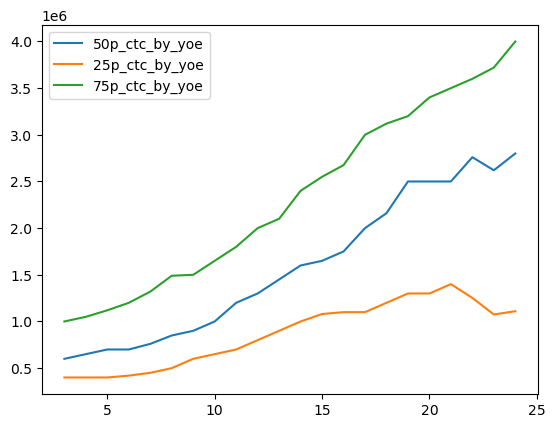

In [142]:
plt.plot(df_grp_yoe['yoe'].values, df_grp_yoe['ctc_50%'].values, label='50p_ctc_by_yoe')
plt.plot(df_grp_yoe['yoe'].values, df_grp_yoe['ctc_25%'].values, label='25p_ctc_by_yoe')
plt.plot(df_grp_yoe['yoe'].values, df_grp_yoe['ctc_75%'].values, label='75p_ctc_by_yoe')
plt.legend()
plt.show()

In [143]:
df_grp_yoe_merge = pd.merge(df_grp_job_merge.drop(['ctc_25%','ctc_50%','ctc_75%','yoe_25%','yoe_50%','yoe_75%'], axis=1), 
                            df_grp_yoe.iloc[:, [0, 5, 6, 7]], on=['yoe'], how='left')
df_grp_yoe_merge.head()

email_hash           company_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...              bxwqgogen   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...           nqsn axsxnvr   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...  bxwqgotbx wgqugqvnxgz   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...           fvrbvqn rvmo   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...              vqtkkgopj   

         job_position   yoe  ctc_updated_year      ctc  designation  class  \
0    backend engineer  12.0            2019.0  3500000            1      1   
1    backend engineer  11.0            2020.0   336000            2      2   
2  fullstack engineer  20.0            2021.0  2000000            2      1   
3  fullstack engineer  15.0            2018.0  3400000            3      1   
4   frontend engineer   8.0            2020.0   750000            2      2   

   tier  seniority_comp  tier_job  seniority_job    ctc_25%    ctc_50%  \
0     1               1         1              1   800000.0  1300000.0   
1     2               2         3              1   700000.0  1200000.0   
2     2               1         1              1  1300000.0  2500000.0   
3     1               1         1              1  1080000.0  1650000.0   
4     2               2         2              2   500000.0   850000.0   

     ctc_75%  
0  2000000.0  
1  1800000.0  
2  3400000.0  
3  2550000.0  
4  1490000.0

In [144]:
def tier_yoe_logic(ctc, ctc_grp_median, ctc_grp_25p, ctc_grp_75p):
    if ctc > 1.3*ctc_grp_median:
        return 1
    elif ctc_grp_median > 1.3*ctc:
        return 3
    return 2
    
    # if ctc > ctc_grp_75p:
    #     return 1
    # elif ctc < ctc_grp_25p:
    #     return 3
    # return 2

df_grp_yoe_merge['tier_yoe'] = df_grp_yoe_merge[['ctc', 'ctc_50%', 
                                                 'ctc_25%', 'ctc_75%']].apply(lambda x: tier_yoe_logic(x[0],x[1],x[2],x[3]), axis=1)
df_grp_yoe_merge['tier_yoe'].value_counts(normalize=True)

3    0.354982
1    0.350054
2    0.294965
Name: tier_yoe, dtype: float64

In [145]:
df_final3 = df_grp_yoe_merge.copy()
df_final3.drop(['ctc_25%','ctc_50%','ctc_75%'], axis=1, inplace=True)
df_final3.head()

email_hash           company_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...              bxwqgogen   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...           nqsn axsxnvr   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...  bxwqgotbx wgqugqvnxgz   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...           fvrbvqn rvmo   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...              vqtkkgopj   

         job_position   yoe  ctc_updated_year      ctc  designation  class  \
0    backend engineer  12.0            2019.0  3500000            1      1   
1    backend engineer  11.0            2020.0   336000            2      2   
2  fullstack engineer  20.0            2021.0  2000000            2      1   
3  fullstack engineer  15.0            2018.0  3400000            3      1   
4   frontend engineer   8.0            2020.0   750000            2      2   

   tier  seniority_comp  tier_job  seniority_job  tier_yoe  
0     1               1         1              1         1  
1     2               2         3              1         3  
2     2               1         1              1         2  
3     1               1         1              1         1  
4     2               2         2              2         2

### **Job Band**
- A DS role in a service based company will pay quite differently for the same DS role in a top-product company
- Similarly DS role in a product company will be pying differently from a Test Engineer in the same product company
- Here we want to essentially capture the job_band for each learner
- Job_band is found out as follows:
    - We form groups depending on the company and job role
    - For each group we find the median ctc offered
    - We split all the groups into 4 bands (as per the quartiles)

In [146]:
df_grp_comp_job_band = df_grp_comp_job[['company_hash', 'job_position', 'ctc_50%']].copy()
job_band_min = df_grp_comp_job_band['ctc_50%'].describe()['min']
job_band_max = df_grp_comp_job_band['ctc_50%'].describe()['max']
job_band_25p = df_grp_comp_job_band['ctc_50%'].describe()['25%']
job_band_50p = df_grp_comp_job_band['ctc_50%'].describe()['50%']
job_band_75p = df_grp_comp_job_band['ctc_50%'].describe()['75%']
print(job_band_min, job_band_25p, job_band_50p, job_band_75p, job_band_max)

336000.0 520000.0 900000.0 1535000.0 20000000.0


In [147]:
df_grp_comp_job_band['ctc_50%'].describe()

count    6.145500e+04
mean     1.482477e+06
std      2.385213e+06
min      3.360000e+05
25%      5.200000e+05
50%      9.000000e+05
75%      1.535000e+06
max      2.000000e+07
Name: ctc_50%, dtype: float64

In [148]:
job_band_bins = [job_band_min-100, job_band_25p, job_band_50p, job_band_75p, job_band_max+100]
job_band_labels=[4, 3, 2, 1]
df_grp_comp_job_band['job_band'] = pd.cut(df_grp_comp_job_band['ctc_50%'], bins=job_band_bins, labels=job_band_labels)
# df_grp_comp_job_band['job_band'].value_counts()
df_grp_comp_job_band.head()

company_hash       job_position    ctc_50% job_band
0                               0              other   336000.0        4
1                            0000              other   336000.0        4
2                      01 ojztqsj   android engineer   336000.0        4
3                      01 ojztqsj  frontend engineer   830000.0        3
4  05mz exzytvrny uqxcvnt rxbxnta   backend engineer  1100000.0        2

In [149]:
df_final4 = pd.merge(df_final3, df_grp_comp_job_band.iloc[:, [0, 1, 3]], on=['company_hash', 'job_position'], how='left')
df_final4.head()

email_hash           company_hash  \
0  00003288036a44374976948c327f246fdbdf0778546904...              bxwqgogen   
1  0000aaa0e6b61f7636af1954b43d294484cd151c9b3cf6...           nqsn axsxnvr   
2  000120d0c8aa304fcf12ab4b85e21feb80a342cfea03d4...  bxwqgotbx wgqugqvnxgz   
3  00014d71a389170e668ba96ae8e1f9d991591acc899025...           fvrbvqn rvmo   
4  00022dc29c7f77032275182b883d4f273ea1007aefc437...              vqtkkgopj   

         job_position   yoe  ctc_updated_year      ctc  designation  class  \
0    backend engineer  12.0            2019.0  3500000            1      1   
1    backend engineer  11.0            2020.0   336000            2      2   
2  fullstack engineer  20.0            2021.0  2000000            2      1   
3  fullstack engineer  15.0            2018.0  3400000            3      1   
4   frontend engineer   8.0            2020.0   750000            2      2   

   tier  seniority_comp  tier_job  seniority_job  tier_yoe job_band  
0     1               1         1              1         1        1  
1     2               2         3              1         3        4  
2     2               1         1              1         2        2  
3     1               1         1              1         1        1  
4     2               2         2              2         2        3

In [152]:
# Saving data (cleaned + feature_engg done, different versions)
# df_final2.to_csv('./data/df_final2.csv')
# df_final3.to_csv('./data/df_final3.csv')
# df_final4.to_csv('./data/df_final4.csv')

In [153]:
# Loading data (cleaned + feature_engg done, different versions)
# df_final2 = pd.read_csv('./data/df_final2.csv')
# df_final3 = pd.read_csv('./data/df_final3.csv')
# df_final4 = pd.read_csv('./data/df_final4.csv')

# **KMeans:**

In [154]:
pipe_stdscl = Pipeline([('std_scaler', StandardScaler())])

In [155]:
# Function computes dunn_index
def compute_dunn_index(X, label, centroids):
    
    # Calculates pairwise distance b/w cluster centroids
    inter_cluster_arr = pdist(centroids)
    
    # Below array will store the maximum intra_cluster distance fr each cluster
    intra_cluster_arr = np.zeros(len(centroids))
    for i in range(len(centroids)):
        cluster_pts = X[label==i]
        if len(cluster_pts)>1:
            intra_cluster_arr[i] = np.max(pdist(cluster_pts))

    
    
    wc_inter_cluster_dis = np.min(inter_cluster_arr)
    wc_intra_cluster_dis = np.max(intra_cluster_arr)
    dunn_index = wc_inter_cluster_dis/wc_intra_cluster_dis
    return np.round(dunn_index, 4)

## **KMeans: Trial1**
- ctc_log can be removed since it seems like a redundant variable (we can infer about ctc by looking at other variables)
- In next trail (Trail2), we add some extra features while performing clustering for better interpretation of results

In [156]:
df_final_ml2 = df_final2.copy()

df_final_ml2['ctc_log'] = np.log(df_final_ml2['ctc'])
df_final_ml2.drop(['email_hash', 'company_hash', 'job_position', 'ctc_updated_year', 'ctc'], axis=1, inplace=True)

df_final_ml2.head()

yoe  designation  class  tier    ctc_log
0  12.0            1      1     1  15.068274
1  11.0            2      2     2  12.724866
2  20.0            2      1     2  14.508658
3  15.0            3      1     1  15.039286
4   8.0            2      2     2  13.527828

In [157]:
X_scaled2 = pipe_stdscl.fit_transform(df_final_ml2)

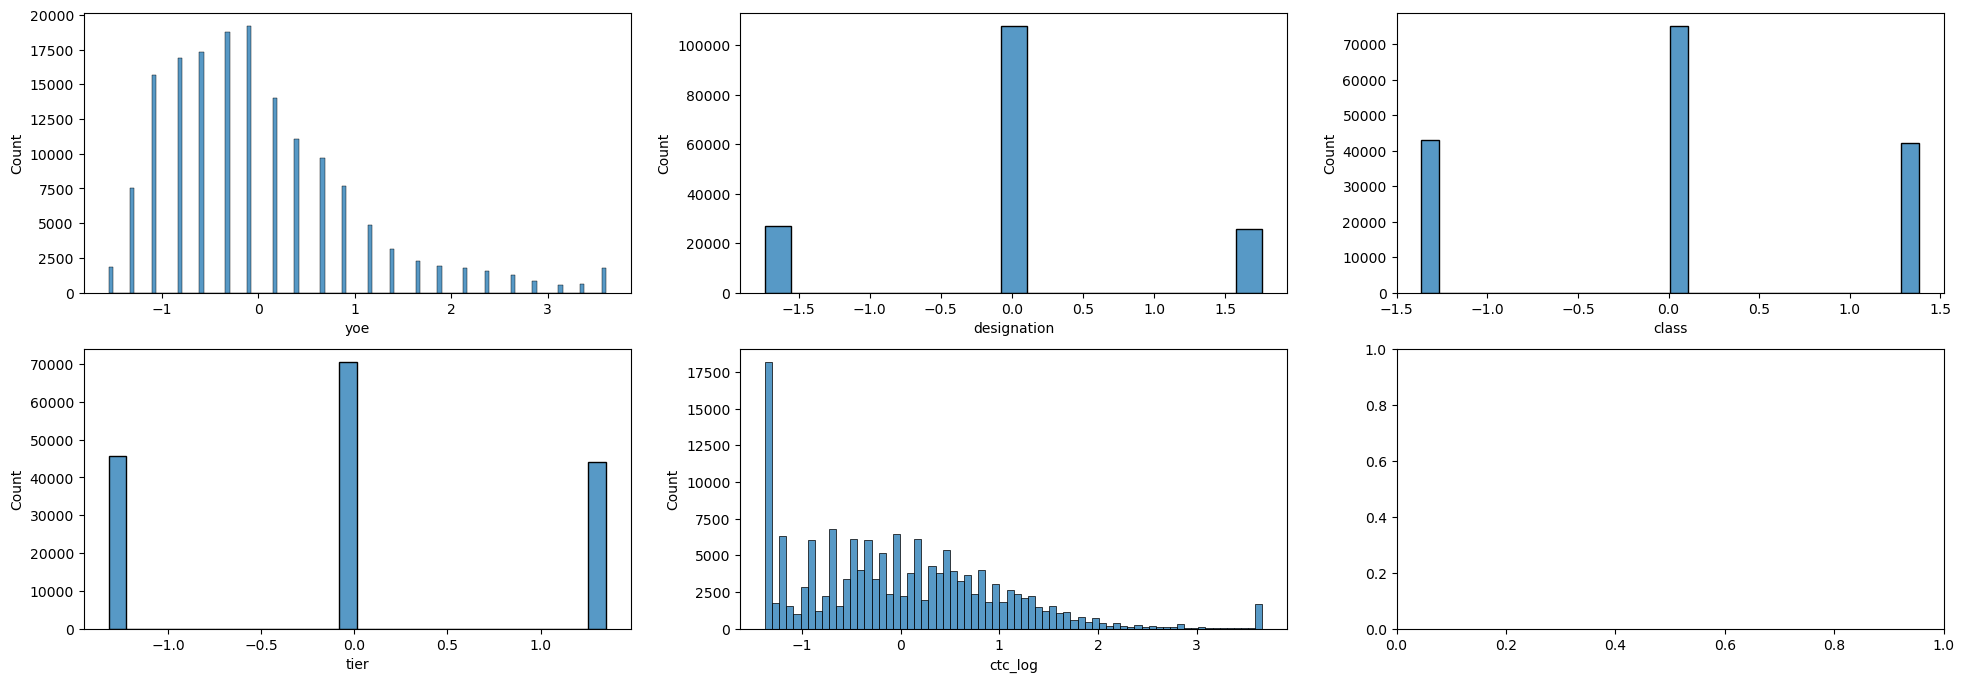

In [158]:
df_final_ml_scl2 = pd.DataFrame(X_scaled2, columns=df_final_ml2.columns)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 8))

i = 0
for col in df_final_ml_scl2.columns[:3]:
    if col=='ctc_log':
        sns.histplot(df_final_ml_scl2[col], ax=axs[0][i], bins=70) 
    else:
        sns.histplot(df_final_ml_scl2[col], ax=axs[0][i])
    i += 1
    
i = 0
for col in df_final_ml_scl2.columns[3:]:
    if col=='ctc_log':
        sns.histplot(df_final_ml_scl2[col], ax=axs[1][i], bins=70) 
    else:
        sns.histplot(df_final_ml_scl2[col], ax=axs[1][i])
    i += 1    

In [159]:
wcss2 = {}
dn_idx2 = {}
for k in range(2, 11):
    kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_scaled2)
    wcss2[k] = kmeans.inertia_
    dn_idx2[k]=compute_dunn_index(X_scaled2, kmeans.labels_, kmeans.cluster_centers_)
    

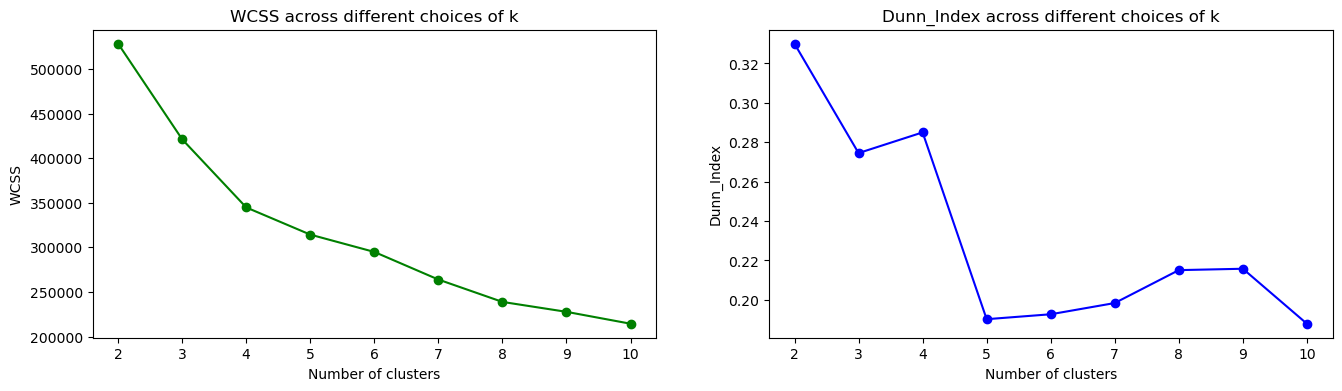

In [160]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

axs[0].plot(list(wcss2.keys()), list(wcss2.values()), c='g', marker='o', label='wcss')
axs[0].set_xlabel("Number of clusters")
axs[0].set_ylabel("WCSS")
axs[0].set_title("WCSS across different choices of k")

axs[1].plot(list(dn_idx2.keys()), list(dn_idx2.values()), c='b', marker='o', label='wcss')
axs[1].set_xlabel("Number of clusters")
axs[1].set_ylabel("Dunn_Index")
axs[1].set_title("Dunn_Index across different choices of k")
plt.show()

In [161]:
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init='auto')
kmeans2.fit(X_scaled2)

KMeans(n_clusters=4, n_init='auto', random_state=42)

In [162]:
pd.Series(kmeans2.labels_).value_counts(normalize=True)

1    0.409746
2    0.216695
0    0.193757
3    0.179802
dtype: float64

In [163]:
df_final_ml_scl2['labels'] = kmeans2.labels_
df_final_ml_scl2.head()

yoe  designation     class      tier   ctc_log  labels
0  0.655225    -1.736119 -1.363600 -1.322130  1.515773       0
1  0.409664     0.012655  0.008637  0.014551 -1.374357       1
2  2.619718     0.012655 -1.363600  0.014551  0.825597       3
3  1.391910     1.761428 -1.363600 -1.322130  1.480022       3
4 -0.327021     0.012655  0.008637  0.014551 -0.384062       1

In [164]:
polar2 = df_final_ml_scl2.groupby('labels').mean()
polar2 = polar2.reset_index()
polar2 = pd.melt(polar2, id_vars=['labels'])
polar2.head()

labels     variable     value
0       0          yoe -0.271773
1       1          yoe -0.317424
2       2          yoe -0.357814
3       3          yoe  1.447467
4       0  designation -1.263680

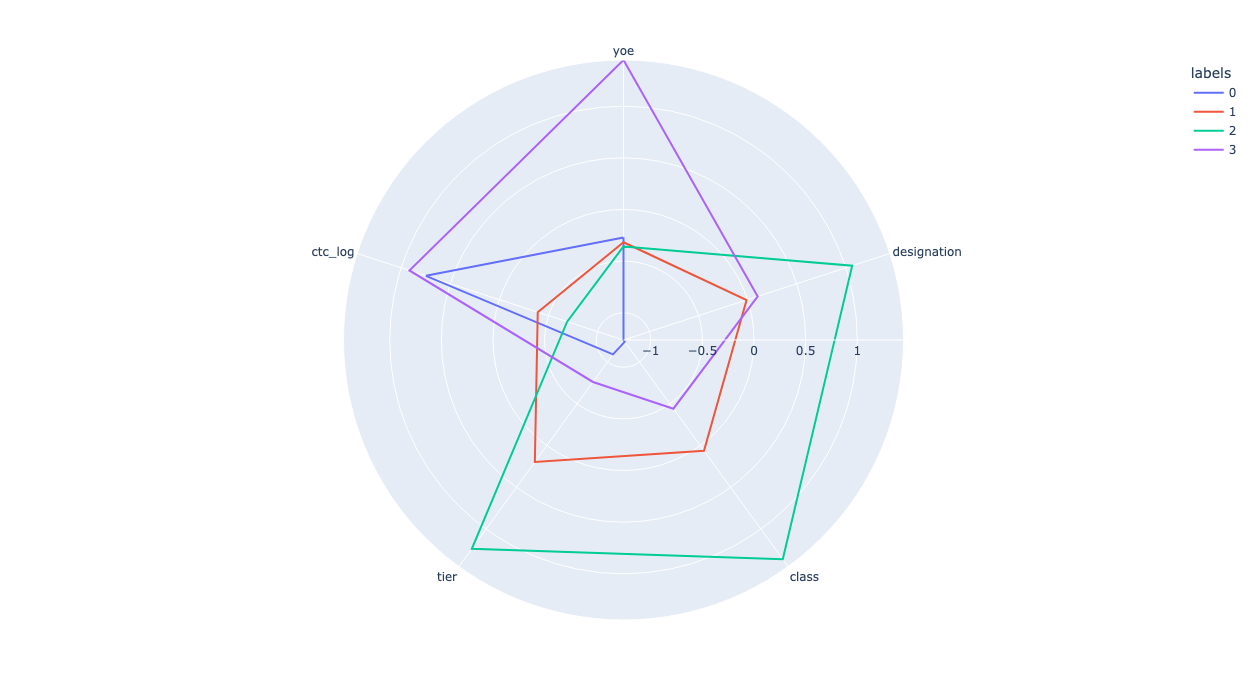

In [165]:
fig = px.line_polar(polar2, r="value", theta="variable", color="labels", line_close=True,height=700,width=800)
fig.show()

## **KMeans: Trial2**
- Experiemnts showed that yoe, seniority_comp, senirity_yoe tend to give the same insights, hence we keep only 1 feature among those
- Designation feature does not seem to be well seperated amongst the different clusters formed, hence dropping it.
- In next trail (Trail3) we add job_band to better infer the results of clustering

In [166]:
df_final_ml3 = df_final3.copy()

df_final_ml3['ctc_log'] = np.log(df_final_ml3['ctc'])
df_final_ml3.drop(['email_hash', 'company_hash', 'job_position', 'ctc_updated_year', 'ctc'], axis=1, inplace=True)
df_final_ml3.drop(['designation', 'seniority_comp', 'seniority_job', 'ctc_log'], axis=1, inplace=True)

df_final_ml3.head()

yoe  class  tier  tier_job  tier_yoe
0  12.0      1     1         1         1
1  11.0      2     2         3         3
2  20.0      1     2         1         2
3  15.0      1     1         1         1
4   8.0      2     2         2         2

In [167]:
X_scaled3 = pipe_stdscl.fit_transform(df_final_ml3)

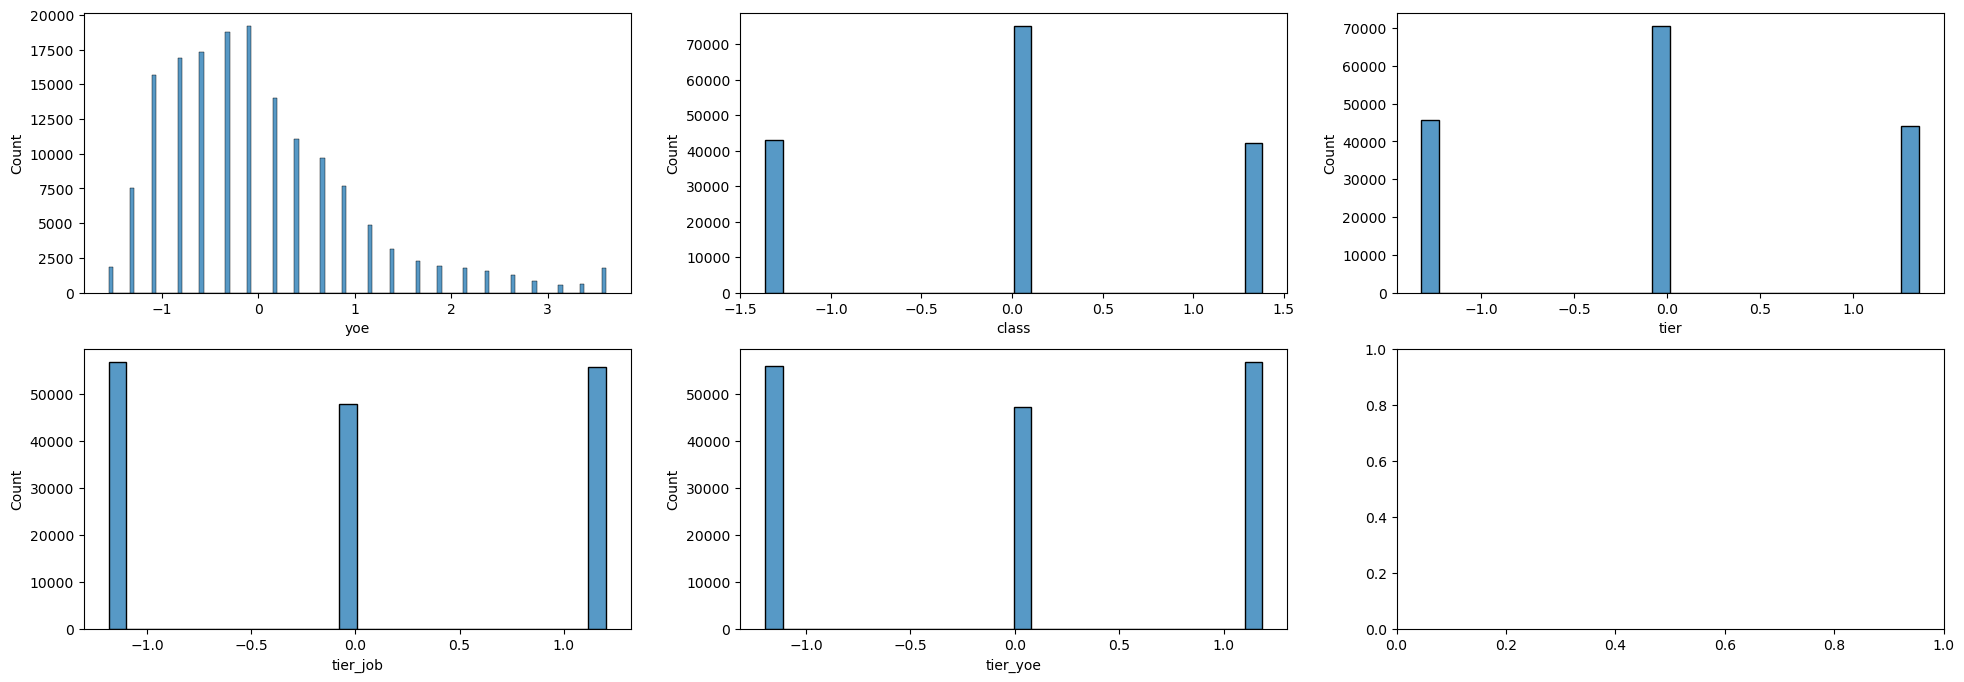

In [168]:
df_final_ml_scl3 = pd.DataFrame(X_scaled3, columns=df_final_ml3.columns)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 8))

i = 0
for col in df_final_ml_scl3.columns[:3]:
    if col=='ctc_log':
        sns.histplot(df_final_ml_scl3[col], ax=axs[0][i], bins=70) 
    else:
        sns.histplot(df_final_ml_scl3[col], ax=axs[0][i])
    i += 1
    
i = 0
for col in df_final_ml_scl3.columns[3:]:
    if col=='ctc_log':
        sns.histplot(df_final_ml_scl3[col], ax=axs[1][i], bins=70) 
    else:
        sns.histplot(df_final_ml_scl3[col], ax=axs[1][i])
    i += 1 

In [169]:
wcss3 = {}
dn_idx3 = {}
for k in range(2, 11):
    kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_scaled3)
    wcss3[k] = kmeans.inertia_
    dn_idx3[k]=compute_dunn_index(X_scaled3, kmeans.labels_, kmeans.cluster_centers_)

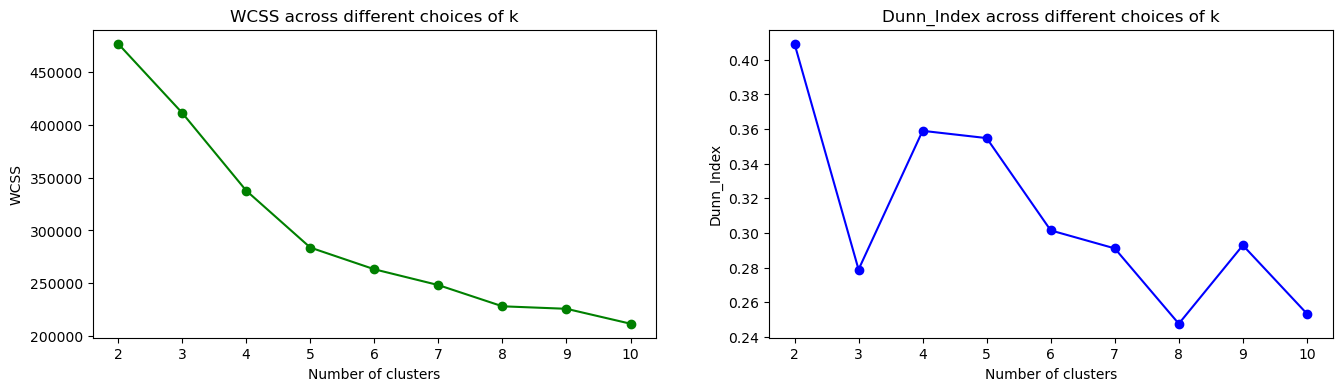

In [170]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

axs[0].plot(list(wcss3.keys()), list(wcss3.values()), c='g', marker='o', label='wcss')
axs[0].set_xlabel("Number of clusters")
axs[0].set_ylabel("WCSS")
axs[0].set_title("WCSS across different choices of k")

axs[1].plot(list(dn_idx3.keys()), list(dn_idx3.values()), c='b', marker='o', label='wcss')
axs[1].set_xlabel("Number of clusters")
axs[1].set_ylabel("Dunn_Index")
axs[1].set_title("Dunn_Index across different choices of k")
plt.show()

In [171]:
kmeans3 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init='auto')
kmeans3.fit(X_scaled3)

KMeans(n_clusters=5, n_init='auto', random_state=42)

In [172]:
pd.Series(kmeans3.labels_).value_counts(normalize=True)

1    0.237723
3    0.234779
0    0.221698
4    0.201342
2    0.104458
dtype: float64

In [173]:
df_final_ml_scl3['labels'] = kmeans3.labels_
df_final_ml_scl3.head()

yoe     class      tier  tier_job  tier_yoe  labels
0  0.655225 -1.363600 -1.322130 -1.185996 -1.196843       0
1  0.409664  0.008637  0.014551  1.202370  1.185104       4
2  2.619718 -1.363600  0.014551 -1.185996 -0.005869       2
3  1.391910 -1.363600 -1.322130 -1.185996 -1.196843       0
4 -0.327021  0.008637  0.014551  0.008187 -0.005869       3

In [174]:
polar3 = df_final_ml_scl3.groupby('labels').mean()
polar3 = polar3.reset_index()
polar3 = pd.melt(polar3, id_vars=['labels'])
polar3.head()

labels variable     value
0       0      yoe -0.087484
1       1      yoe -0.377946
2       2      yoe  2.055593
3       3      yoe -0.279606
4       4      yoe -0.197849

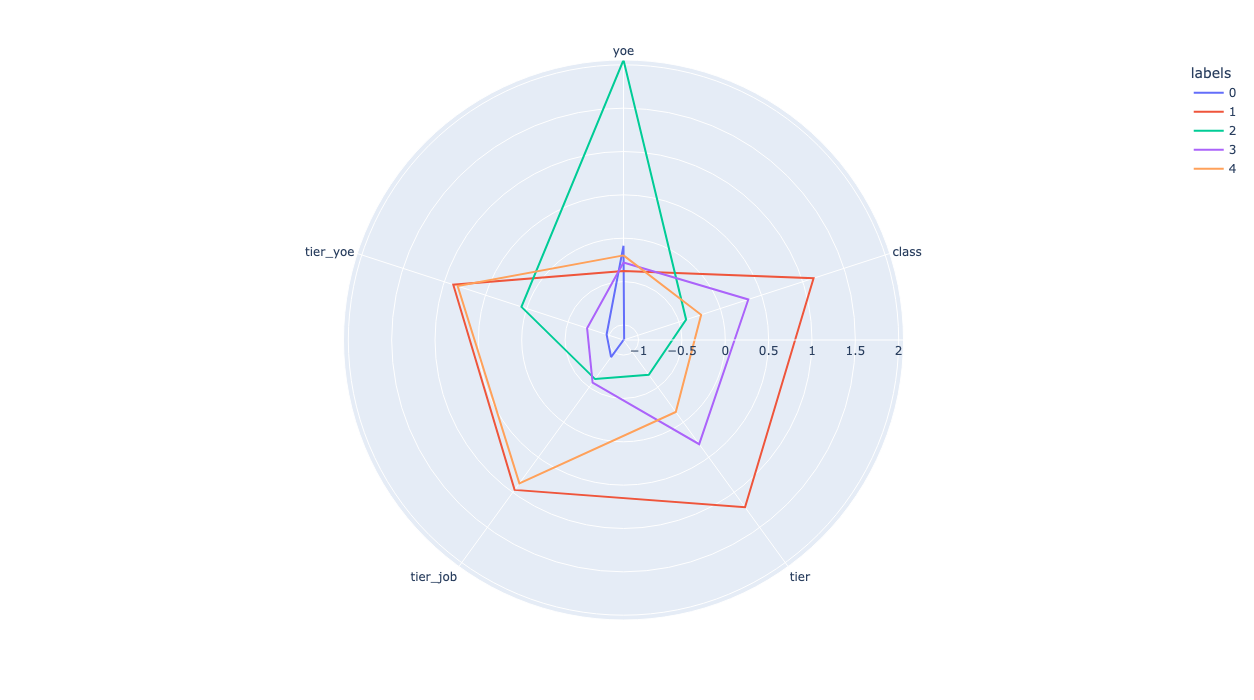

In [175]:
fig = px.line_polar(polar3, r="value", theta="variable", color="labels", line_close=True,height=700,width=800)
fig.show()

## **KMeans: Trial3**
- We achieve results which are interpretable and are making intuitive sense with the below features
- We aimed for 5 clusters to keep things simple and to make it easy for result interpretation
- With 5 clusters, we achieved relatively uniform split amongst different clusters without too much skew in any 1 of them

In [176]:
df_final_ml4 = df_final4.copy()

df_final_ml4['ctc_log'] = np.log(df_final_ml4['ctc'])
df_final_ml4.drop(['email_hash', 'company_hash', 'job_position', 'ctc_updated_year', 'ctc'], axis=1, inplace=True)
df_final_ml4.drop(['designation', 'seniority_comp', 'seniority_job', 'ctc_log'], axis=1, inplace=True)

df_final_ml4.head()

yoe  class  tier  tier_job  tier_yoe job_band
0  12.0      1     1         1         1        1
1  11.0      2     2         3         3        4
2  20.0      1     2         1         2        2
3  15.0      1     1         1         1        1
4   8.0      2     2         2         2        3

In [177]:
X_scaled4 = pipe_stdscl.fit_transform(df_final_ml4)

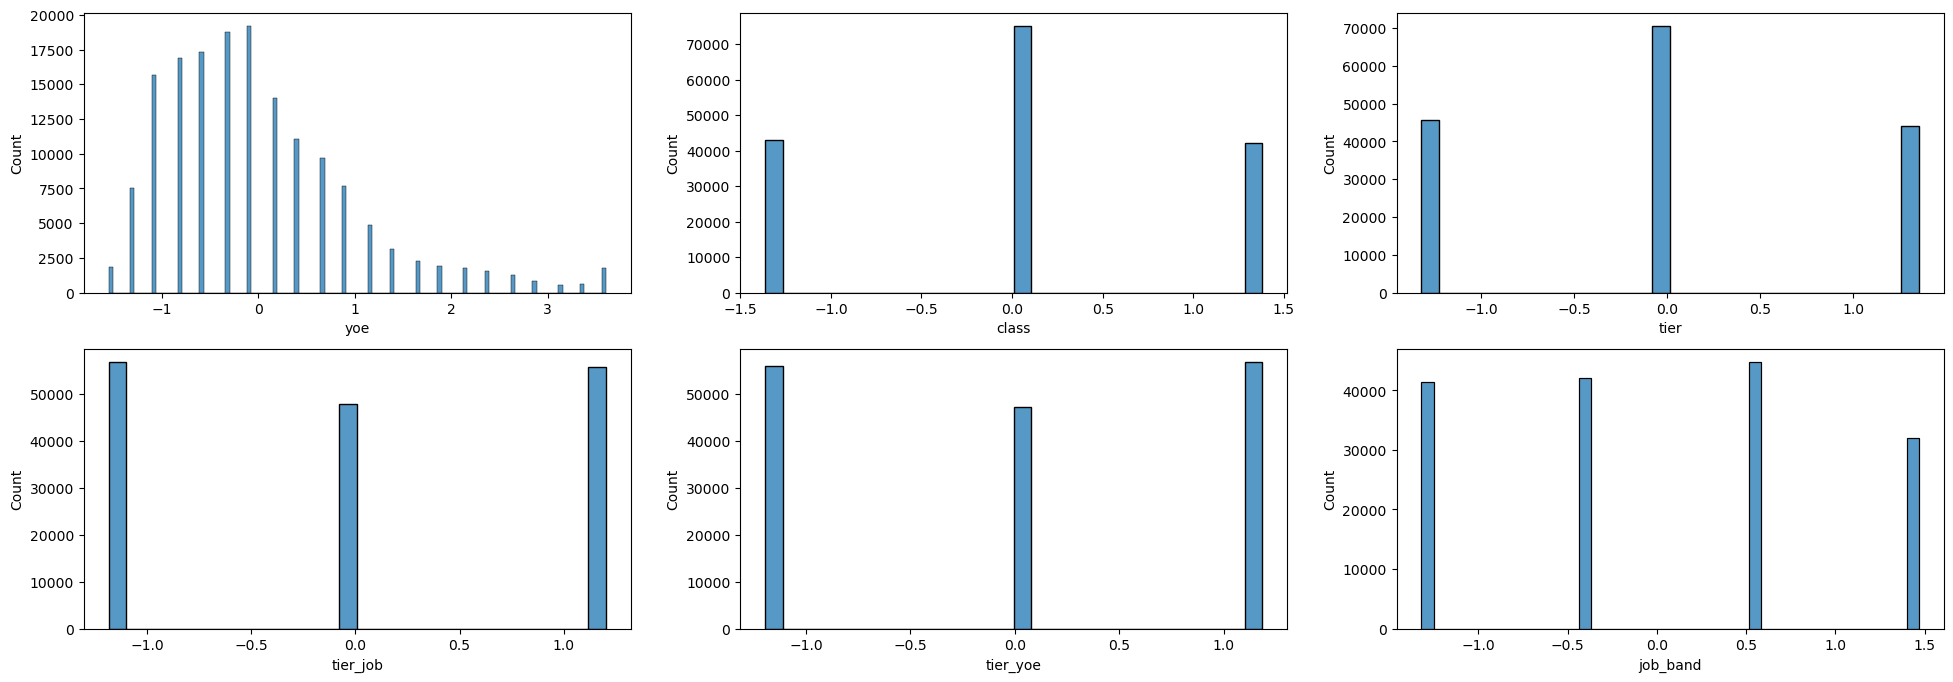

In [178]:
df_final_ml_scl4 = pd.DataFrame(X_scaled4, columns=df_final_ml4.columns)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 8))

i = 0
for col in df_final_ml_scl4.columns[:3]:
    if col=='ctc_log':
        sns.histplot(df_final_ml_scl4[col], ax=axs[0][i], bins=70) 
    else:
        sns.histplot(df_final_ml_scl4[col], ax=axs[0][i])
    i += 1
    
i = 0
for col in df_final_ml_scl4.columns[3:]:
    if col=='ctc_log':
        sns.histplot(df_final_ml_scl4[col], ax=axs[1][i], bins=70) 
    else:
        sns.histplot(df_final_ml_scl4[col], ax=axs[1][i])
    i += 1 

In [179]:
wcss4 = {}
dn_idx4 = {}
for k in range(2, 11):
    kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_scaled4)
    wcss4[k] = kmeans.inertia_
    dn_idx4[k]=compute_dunn_index(X_scaled4, kmeans.labels_, kmeans.cluster_centers_)

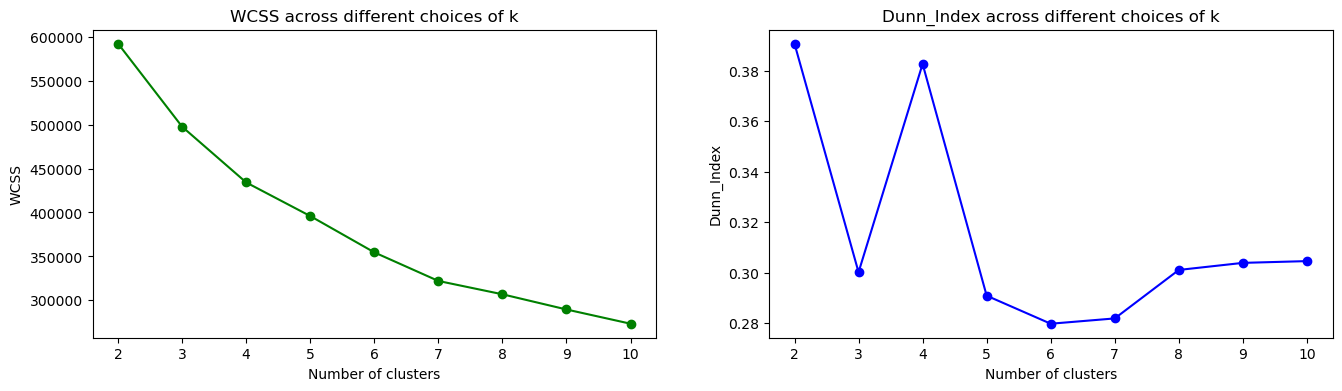

In [180]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

axs[0].plot(list(wcss4.keys()), list(wcss4.values()), c='g', marker='o', label='wcss')
axs[0].set_xlabel("Number of clusters")
axs[0].set_ylabel("WCSS")
axs[0].set_title("WCSS across different choices of k")

axs[1].plot(list(dn_idx4.keys()), list(dn_idx4.values()), c='b', marker='o', label='wcss')
axs[1].set_xlabel("Number of clusters")
axs[1].set_ylabel("Dunn_Index")
axs[1].set_title("Dunn_Index across different choices of k")
plt.show()

In [181]:
kmeans4 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init='auto')
kmeans4.fit(X_scaled4)

KMeans(n_clusters=5, n_init='auto', random_state=42)

In [182]:
pd.Series(kmeans4.labels_).value_counts(normalize=True)

0    0.258297
4    0.248584
3    0.207082
1    0.165479
2    0.120558
dtype: float64

In [183]:
df_final_ml_scl4['labels'] = kmeans4.labels_
df_final_ml_scl4.head()

yoe     class      tier  tier_job  tier_yoe  job_band  labels
0  0.655225 -1.363600 -1.322130 -1.185996 -1.196843 -1.318077       0
1  0.409664  0.008637  0.014551  1.202370  1.185104  1.466528       4
2  2.619718 -1.363600  0.014551 -1.185996 -0.005869 -0.389875       2
3  1.391910 -1.363600 -1.322130 -1.185996 -1.196843 -1.318077       2
4 -0.327021  0.008637  0.014551  0.008187 -0.005869  0.538326       4

In [184]:
polar4 = df_final_ml_scl4.groupby('labels').mean()
polar4 = polar4.reset_index()
polar4 = pd.melt(polar4, id_vars=['labels'])
polar4.head()

labels variable     value
0       0      yoe -0.160437
1       1      yoe -0.270192
2       2      yoe  1.885015
3       3      yoe -0.391303
4       4      yoe -0.241654

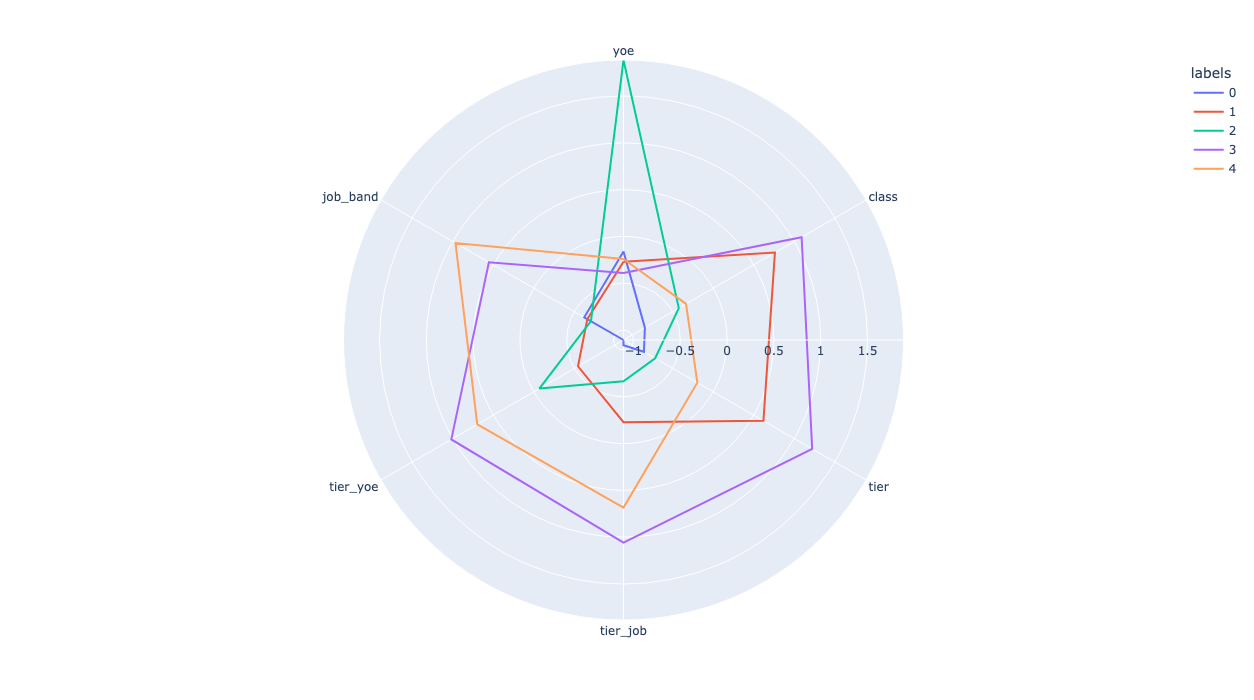

In [185]:
fig = px.line_polar(polar4, r="value", theta="variable", color="labels", line_close=True,height=700,width=800)
fig.show()

Explained Variance Ratio: [0.50348877 0.21423317]


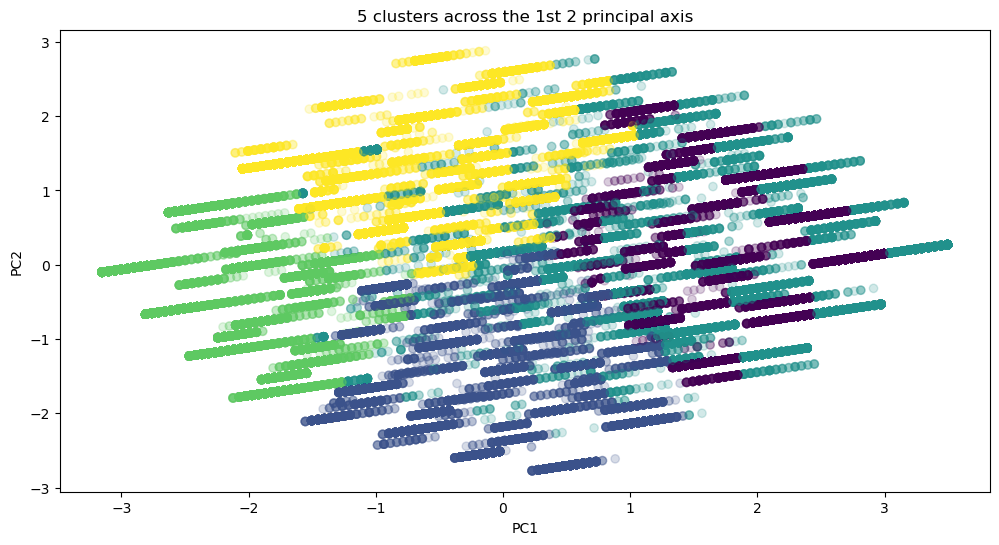

In [186]:
pca = PCA(n_components=2)
pca.fit(X_scaled4)
print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')

X_scaled4_pca2 = pca.transform(X_scaled4)
X_scaled4_pca2


df_scaled4_pca2 = pd.DataFrame(X_scaled4_pca2, columns=['pc1', 'pc2'])
df_scaled4_pca2['labels'] = kmeans4.labels_
df_scaled4_pca2.head()


plt.figure(figsize=(12,6))
plt.scatter(df_scaled4_pca2['pc1'].values, df_scaled4_pca2['pc2'].values, alpha=0.2, c=df_scaled4_pca2['labels'])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('5 clusters across the 1st 2 principal axis')
plt.show()

In [188]:
polar4_cp = polar4.copy()
polar4_cp['rank'] = polar4_cp.groupby(['variable'])['value'].rank()
polar4_cp = pd.pivot(polar4_cp.iloc[:, [0, 1, 3]], index='labels', columns='variable')
polar4_cp.columns = [('_').join(tup) for tup in polar4_cp.columns]
learner_persona = {0:'champions', 1:'stable', 2:'pre-champions', 3:'weaklings', 4:'aspirers'}
polar4_cp['learner_persona'] = learner_persona
polar4_cp

rank_class  rank_job_band  rank_tier  rank_tier_job  rank_tier_yoe  \
labels                                                                       
0              1.0            3.0        1.0            1.0            1.0   
1              4.0            2.0        4.0            3.0            2.0   
2              2.0            1.0        2.0            2.0            3.0   
3              5.0            4.0        5.0            5.0            5.0   
4              3.0            5.0        3.0            4.0            4.0   

        rank_yoe learner_persona  
labels                            
0            4.0       champions  
1            2.0          stable  
2            5.0   pre-champions  
3            1.0       weaklings  
4            3.0        aspirers

## **BEST companies, job_positions and jobs (company+job_position combinations):**
- We zoom into the learners who are identified as champions
- After isolating the champions, we can identify the best companies and job positions to work for from the Scaler database 

In [189]:
df_final4['labels'] = kmeans4.labels_
df_final4_champions = df_final4.loc[df_final4['labels']==0, ['email_hash', 'company_hash', 'job_position', 'yoe', 'ctc', 'labels']].copy()
df_final4_champions.head()

email_hash       company_hash  \
0   00003288036a44374976948c327f246fdbdf0778546904...          bxwqgogen   
6   000411b5d6d4e1c113bf83f1eebc0b835d77cc45bded1d...            gutzcgj   
7   000411b5d6d4e1c113bf83f1eebc0b835d77cc45bded1d...  sgowvrt sqghu xzw   
11  000467b0e6a1fcc95b882052b63d0d783196327087f76b...      thrtq ojontbo   
20  000c89400932b5cc8a3d6c5b6a854c844f0f64a53d7b8a...           evwtmggp   

          job_position   yoe      ctc  labels  
0     backend engineer  12.0  3500000       0  
6     backend engineer   7.0  3500000       0  
7    frontend engineer   7.0  1600000       0  
11    backend engineer   5.0  3600000       0  
20  fullstack engineer   9.0  2100000       0

In [190]:
# Top20 most frequent companies where champions work at:
df_final4_champions['company_hash'].value_counts().iloc[:20]

vbvkgz                                   1235
bxwqgogen                                 805
zvz                                       605
gqvwrt                                    586
zgn vuurxwvmrt vwwghzn                    527
vagmt                                     472
nvnv wgzohrnvzwj otqcxwto                 471
eqtoytq                                   431
zgn vuurxwvmrt                            427
uvjnb                                     414
erxupvqn                                  408
xzegojo                                   360
vwwtznhqt                                 349
sgrabvz ovwyo                             330
ovbohzs qa xzonxnhnt xzaxv  mvzsvrgqt     329
lubgqsvz wyvot  wg                        307
fvrbvqn rvmo                              289
wgszxkvzn                                 271
wxowg                                     255
fxuqg rxbxnta                             245
Name: company_hash, dtype: int64

In [191]:
# Top20 most frequent job_positions where champions work at:
df_final4_champions['job_position'].value_counts().iloc[:20]

backend engineer          14615
fullstack engineer         7911
other                      4446
frontend engineer          2644
data scientist             1892
android engineer           1240
engineering leadership     1027
qa engineer                 950
engineering intern          922
devops engineer             910
sdet                        810
support engineer            799
data analyst                702
ios engineer                599
research engineer           451
product manager             388
product designer            207
backend architect           150
database administrator      119
co-founder                  116
Name: job_position, dtype: int64

In [192]:
# Top20 most frequent (company+job_positions) combinations where champions work at:
df_final4_champions.groupby(['company_hash', 'job_position'])['email_hash'].count().sort_values(ascending=False).iloc[:20]

company_hash                           job_position      
vbvkgz                                 backend engineer      637
bxwqgogen                              backend engineer      406
gqvwrt                                 backend engineer      285
erxupvqn                               backend engineer      282
vbvkgz                                 fullstack engineer    268
eqtoytq                                other                 253
vagmt                                  backend engineer      233
uvjnb                                  backend engineer      228
bxwqgogen                              fullstack engineer    210
zvz                                    backend engineer      175
fvrbvqn rvmo                           backend engineer      168
sgrabvz ovwyo                          backend engineer      165
gqvwrt                                 fullstack engineer    159
ovbohzs qa xzonxnhnt xzaxv  mvzsvrgqt  backend engineer      150
zvz                             

# **Hierarchical Clustering: Experimental**
- Due to compute constraints, we take a random sample from the dataset (25%) and perform hierarchical clustering on it
- From the below dendrogram, the optimal #clusters seems to be anywhere between 3-6

In [193]:
df_final_ml5 = df_final4.copy()
df_final_ml5.drop(['email_hash', 'company_hash', 'job_position', 'ctc_updated_year', 'ctc', 
                   'designation', 'seniority_comp', 'seniority_job', 'labels'], axis=1, inplace=True)
df_final_ml5.head()

yoe  class  tier  tier_job  tier_yoe job_band
0  12.0      1     1         1         1        1
1  11.0      2     2         3         3        4
2  20.0      1     2         1         2        2
3  15.0      1     1         1         1        1
4   8.0      2     2         2         2        3

In [194]:
retain_sample_pct = 0.25
rows_to_retain = round(retain_sample_pct*df_final_ml5.shape[0])
# rows_to_retain
df_final_ml5_sample = df_final_ml5.sample(rows_to_retain).copy()
df_final_ml5_sample.shape

(40076, 6)

In [195]:
X_scaled5 = pipe_stdscl.fit_transform(df_final_ml5_sample)
X_scaled5.shape

(40076, 6)

In [196]:
Z1 = sch.linkage(X_scaled5, method='ward') #linkage = ward
Z1.shape

(40075, 4)

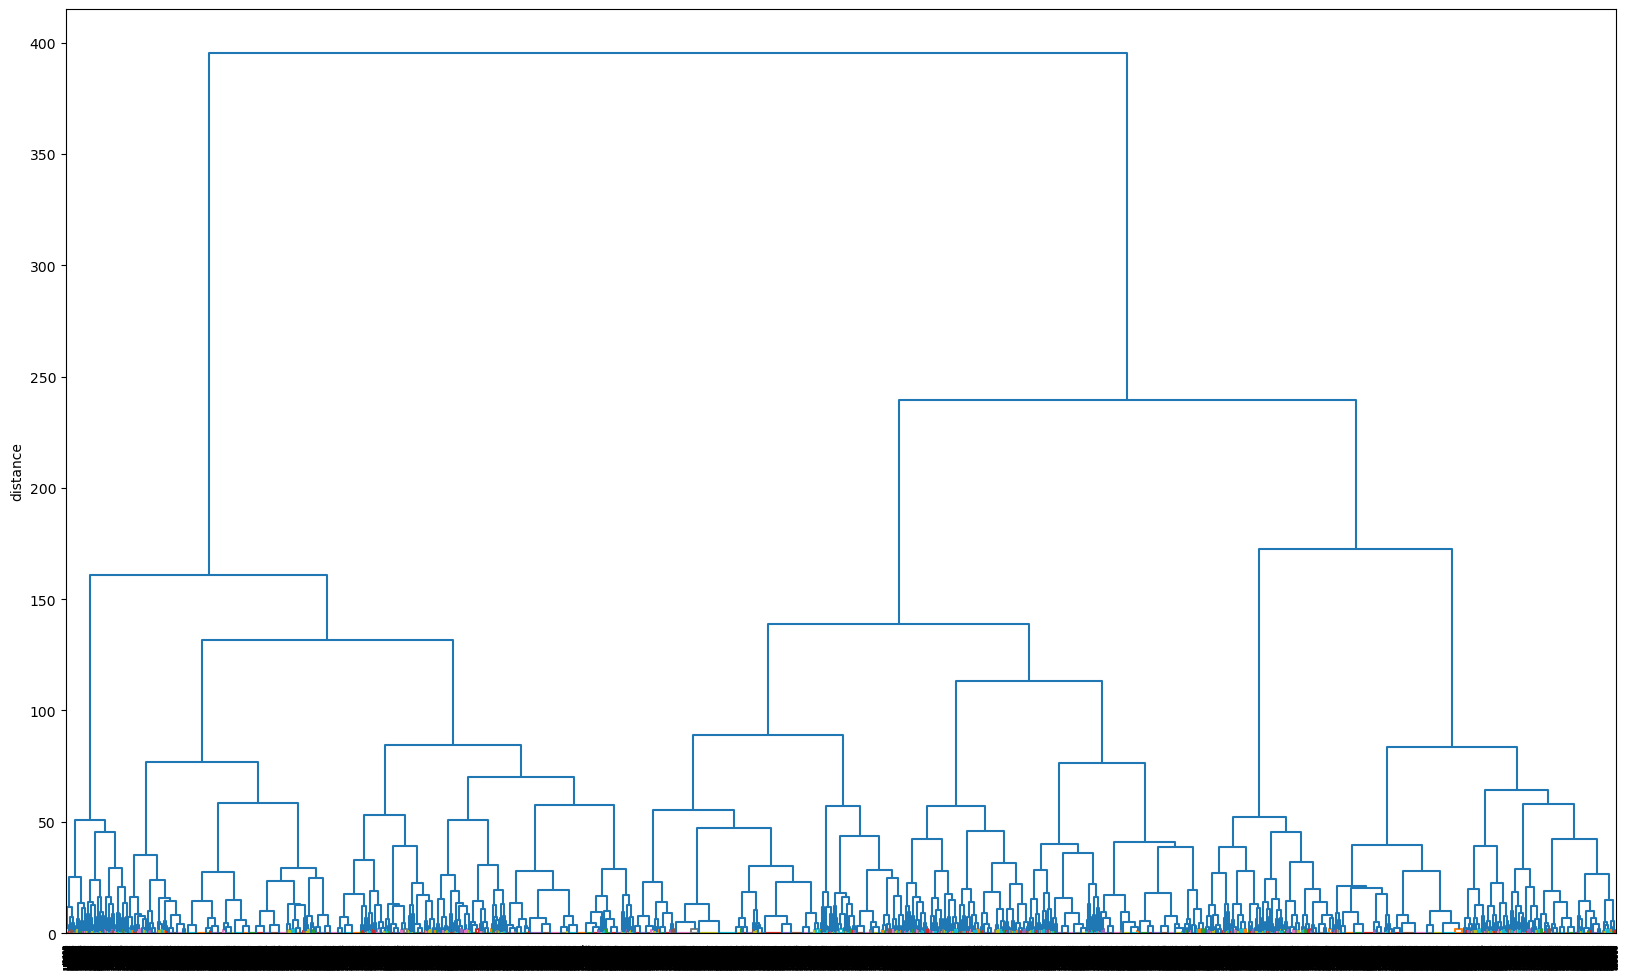

In [197]:
fig, ax = plt.subplots(figsize=(20, 12))
sch.dendrogram(Z1, labels=df_final_ml5_sample.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
ax.set_ylabel('distance')
plt.show()

# **Insights & Recommendations:**

***Below are the different learner personas identified:***

**1. CHAMPIONS: (Cluster0): 26% of learners**:
- Are learners who are mostly working in jobs in the top job_band. 
    - Top job_bands are those (company,job) combinations which pay better across the entire population
- High earners compared to people: 
    - in same company (tier)
    - with same job position (tier_job)
    - with same years of experience in current company and job (tier_yoe)
    - in same company & same job position (class)
 
**2. PRE-CHAMPIONS: (Cluster2): 12% of learners:**
- Are learners who are mostly working in jobs in the top job_band.
    - Top job_bands are those (company,job) combinations which pay better across the entire population
- They are moderately high earners compared to people: 
    - in the same company (tier)
    - with same job position (tier_job)
    - in same company & same job position (class)
- The are average earners compared to people:
    - with same years of experience in current company and job (tier_yoe)
- Also this group mostly consists of learners with high years of experience in their current company and job, significantly greater than the rest of the population.
    

**3. STABLE: (Cluster1): 16% of learners**: 
- Are learners who are mostly working in jobs in the top job_band. 
    - Top job_bands are those (company,job) combinations which pay better across the entire population
- They are moderately high earners compared to people: 
    - with same job position (tier_job)
    - with same years of experience in current company and job (tier_yoe)
- The are average to moderately low earners compared to people:
    - in the same company (tier)
    - in same company & same job position (class)
- These learners are mostly working in high paying companies (like FAANG) where the ctc offered for any job position is industry leading.
    
    
**4. ASPIRERS: (Cluster4): 25% of learners**: 
- Are learners who are mostly working in jobs in the low job_band. 
    - Low job_bands are those (company,job) combinations which pay lesser across the entire population
- They are low earners compared to people 
    - with same job position (tier_job)
    - with same years of experience in current company and job (tier_yoe)
- The are moderately high to average  earners compared to people:
    - in the same company (tier)
    - in same company & same job position (class)
- These learners are above-average earners within the same tier/class, but low earners within same tier_job/tier_yoe. These learners can benefit the most by changing their companies to other companies which pay better for same job positions.
    
    
**5. WEAKLINGS: (Cluster3): 21% of learners**:     
- Are learners who are mostly working in jobs in the low job_band. 
    - Low job_bands are those (company,job) combinations which pay lesser across the entire population
- Low earners compared to people: 
    - in same company (tier)
    - with same job position (tier_job)
    - with same years of experience in current company and job (tier_yoe)
    - in same company & same job position (class)  
    
    
    
***We have also identified the most frequent job_positions, companies where our champion learners work at.*** 
- Top5 most frequent companies of champions: vbvkgz, bxwqgogen, zvz, gqvwrt, zgn vuurxwvmrt vwwghzn
- Top5 most frequent job_positions of champions: backend engineer, fullstack engineer, frontend engineer, data scientist, android engineer 


***Recommendations:***
1. Learners with champion/pre-champion personas can be requested to do promotional work for Scaler (to generate leads). They can also be requested to share their insights to help other learners.

2. Learners with stable persona can be pushed to take the next big step in their career. These learners can be allocated mentors who are in senior positions who can guide them with strategies to grow in the corporate ladder.

3. Learners with aspirer persona can be provided with special bootcamps aimed specifically to improve interview performance. These learners have demonstrated high quality by being above average earners in their current organization but their current company pays lesser than the industry for their current job role. Hence making a switch seems to be the obvious decision for them.

4. Leaners with weakling persona can be explored further to understand what is stopping them from improving their carrer outcomes. Accordingly tailored pathways can be assigned to them for better results. Mentors can be allocated, remedial sessions can be conducted depending on need of the hour!

5. Since Dream jobs have been identified, Scaler placement team can work towards bringing in more of similar roles and also making sure candidates are prepared well enough to tackle interviews of dream jobs by doing the necessary market research.